In [223]:
import random
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree
import time

#preprocessing
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder,MultiLabelBinarizer,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,precision_score,recall_score,f1_score,ConfusionMatrixDisplay,mean_squared_error,r2_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
#models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from lightgbm import LGBMClassifier


In [6]:
#read data from files
df = pd.read_csv("data/patient_icd_rx_grouped.csv")
df.sample(10)

PatientID  Age Gender   BMI  Weight_kg  Height_cm  \
36304     372100   33      M  17.7       51.4      170.5   
11364     122700   27      M  25.3       65.1      160.3   
18671     195770   80      F  20.4       54.4      163.1   
22285     231910   23      F  21.3       79.9      193.9   
33395     343010   61      F  33.0       75.9      151.7   
46415     473210   84      M  26.3       73.9      167.6   
29072     299780   83      M  32.6       77.2      153.8   
9344      102500   38      F  29.1       77.7      163.3   
35555     364610   46      F  18.5       50.3      164.9   
48660     495660   80      F  24.3       80.5      181.9   

                                      Chronic_Conditions  \
36304                               Myalgia and myositis   
11364                                             Anemia   
18671                                             Anemia   
22285                               Myalgia and myositis   
33395                                           Insomnia   
46415                                          Pneumonia   
29072                                           Headache   
9344                                Myalgia and myositis   
35555                                          Pneumonia   
48660  Diabetes mellitus without mention of complication   

                                               Symptoms  Diagnosis  \
36304            ['Tenderness, Stiffness, Muscle pain']     729.10   
11364                 ['Fatigue, Pale skin, Dizziness']     285.90   
18671                                     ['Dizziness']     285.90   
22285            ['Tenderness, Stiffness, Muscle pain']     729.10   
33395                                       ['Fatigue']     780.52   
46415                                         ['Fever']     486.00   
29072  ['Nausea, Throbbing pain, Sensitivity to light']     784.00   
9344                                     ['Tenderness']     729.10   
35555             ['Shortness of breath, Cough, Fever']     486.00   
48660                     ['Fatigue, Increased thirst']     250.00   

      Recommended_Medication        NDC Dosage Duration  \
36304        Cyclobenzaprine     939752   10mg   5 days   
11364        Ferrous sulfate    1210649  325mg   5 days   
18671        Ferrous sulfate    1210649  325mg  10 days   
22285        Cyclobenzaprine     939752   10mg   7 days   
33395               Zolpidem    2282550   10mg  10 days   
46415           Azithromycin  167140492  250mg  10 days   
29072            Sumatriptan     245910   50mg   5 days   
9344         Cyclobenzaprine     939752   10mg   5 days   
35555           Azithromycin  167140492  250mg   7 days   
48660              Metformin     931048  500mg   5 days   

      Treatment_Effectiveness Adverse_Reactions  Recovery_Time_Days  
36304                    High           Fatigue                   5  
11364                    High               NaN                   5  
18671                    High              Rash                   5  
22285                    High           Fatigue                   5  
33395                    High            Nausea                   5  
46415                Moderate               NaN                  10  
29072                    High              Rash                   5  
9344                     High              Rash                   5  
35555                    High               NaN                   5  
48660                Moderate           Fatigue                  10

Exploratory Data Analysis

In [8]:

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50094 entries, 0 to 50093
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PatientID                50094 non-null  int64  
 1   Age                      50094 non-null  int64  
 2   Gender                   50094 non-null  object 
 3   BMI                      50094 non-null  float64
 4   Weight_kg                50094 non-null  float64
 5   Height_cm                50094 non-null  float64
 6   Chronic_Conditions       50094 non-null  object 
 7   Symptoms                 50094 non-null  object 
 8   Diagnosis                50094 non-null  float64
 9   Recommended_Medication   50083 non-null  object 
 10  NDC                      50094 non-null  int64  
 11  Dosage                   50094 non-null  object 
 12  Duration                 50094 non-null  object 
 13  Treatment_Effectiveness  50094 non-null  object 
 14  Adverse_Reactions     

In [9]:
df.head(10)

PatientID  Age Gender   BMI  Weight_kg  Height_cm  \
0      10006   37      F  25.5       71.8      167.8   
1      10013   58      F  23.1       82.2      188.8   
2      10017   76      F  19.8       48.4      156.4   
3      10019   51      M  29.9       84.0      167.7   
4      10026   22      F  20.4       51.8      159.4   
5      10027   54      F  21.7       54.3      158.2   
6      10029   67      M  21.9       57.3      161.8   
7      10032   35      M  21.3       67.0      177.4   
8      10033   79      F  23.0       54.2      153.4   
9      10035   40      M  22.2       67.3      174.3   

                                  Chronic_Conditions  \
0                                             SEPSIS   
1                                             SEPSIS   
2                                   HUMERAL FRACTURE   
3                                ALCOHOLIC HEPATITIS   
4                                         STROKE/TIA   
5   MITRAL REGURGITATION;CORONARY ARTERY DISEASE\...   
6                                  SYNCOPE;TELEMETRY   
7                            RIGHT HUMEROUS FRACTURE   
8                RENAL FAILIURE-SYNCOPE-HYPERKALEMIA   
9      RECURRENT LEFT CAROTID STENOSIS,PRE HYDRATION   

                                            Symptoms  Diagnosis  \
0                                             Sepsis    99591.0   
1                             Unspecified septicemia      389.0   
2        Closed fracture of surgical neck of humerus    81201.0   
3                             Unspecified septicemia      389.0   
4                           Intracerebral hemorrhage      431.0   
5              Congestive heart failure, unspecified     4280.0   
6                           Streptococcal septicemia      380.0   
7      Other closed fracture of lower end of humerus    81249.0   
8  Toxic multinodular goiter without mention of t...    24220.0   
9  Occlusion and stenosis of carotid artery witho...    43310.0   

   Recommended_Medication          NDC                  Dosage Duration  \
0               Glipizide  51079081120                10MG TAB   5 days   
1              Furosemide     74610204           40MG/4ML VIAL  14 days   
2           Hydromorphone     74131230          2mg/mL Syringe   5 days   
3                Propofol    310030011       1000mg/100mL Vial  10 days   
4              Metoprolol  55390007310            5mg/5mL Vial   7 days   
5                     NaN    456066270            20mEq Packet   5 days   
6                     NaN    338004904              1000mL Bag   5 days   
7        Prochlorperazine      7336721                10MG TAB   7 days   
8  Polystyrene, Sulfonate  46287000660         15g/60mL Bottle  14 days   
9                 Heparin     74779362  25,000 unit Premix Bag   7 days   

  Treatment_Effectiveness Adverse_Reactions  Recovery_Time_Days  
0                    High            Nausea                   5  
1                    High           Fatigue                   5  
2                Moderate           Fatigue                  10  
3                Moderate               NaN                  10  
4                Moderate            Nausea                  10  
5                Moderate              Rash                  10  
6                    High               NaN                   5  
7                    High            Nausea                   5  
8                     Low               NaN                  15  
9                Moderate            Nausea                  10

In [10]:
print(df.isnull().sum())

PatientID                      0
Age                            0
Gender                         0
BMI                            0
Weight_kg                      0
Height_cm                      0
Chronic_Conditions             0
Symptoms                       0
Diagnosis                      0
Recommended_Medication        11
NDC                            0
Dosage                         0
Duration                       0
Treatment_Effectiveness        0
Adverse_Reactions          24947
Recovery_Time_Days             0
dtype: int64


In [11]:
for col in df.columns:
    print(f"value counts for column '{col}':")
    print(df[col].value_counts(dropna=False))
    

value counts for column 'PatientID':
PatientID
10090     2
10120     2
42430     2
40310     2
43870     2
         ..
176150    1
176160    1
176170    1
176180    1
509990    1
Name: count, Length: 50088, dtype: int64
value counts for column 'Age':
Age
43    753
28    751
75    750
79    745
76    738
     ... 
71    655
49    650
31    648
81    636
87    631
Name: count, Length: 72, dtype: int64
value counts for column 'Gender':
Gender
M    25063
F    25031
Name: count, dtype: int64
value counts for column 'BMI':
BMI
22.5    375
23.3    356
23.9    353
25.6    350
23.1    350
       ... 
52.1      1
55.1      1
47.4      1
50.2      1
5.2       1
Name: count, Length: 447, dtype: int64
value counts for column 'Weight_kg':
Weight_kg
67.2     154
63.4     152
73.5     149
75.3     149
70.9     149
        ... 
24.8       1
23.9       1
112.6      1
113.2      1
27.3       1
Name: count, Length: 989, dtype: int64
value counts for column 'Height_cm':
Height_cm
170.5    227
171.3    221


In [12]:
df.describe()

PatientID           Age           BMI     Weight_kg     Height_cm  \
count   50094.000000  50094.000000  50094.000000  50094.000000  50094.000000   
mean   259558.146604     53.424702     24.480826     70.025566    170.012399   
std    144556.750799     20.724193      6.028929     14.990268     10.016197   
min     10000.000000     18.000000      3.700000     12.700000    125.200000   
25%    134292.500000     36.000000     20.300000     59.900000    163.200000   
50%    259525.000000     53.000000     24.200000     70.000000    170.000000   
75%    384757.500000     71.000000     28.300000     80.100000    176.800000   
max    509990.000000     89.000000     56.100000    134.500000    209.400000   

          Diagnosis           NDC  Recovery_Time_Days  
count  50094.000000  5.009400e+04        50094.000000  
mean     631.112053  7.454888e+07            7.532439  
std     1756.131832  1.354159e+09            3.369803  
min      250.000000  2.459100e+05            5.000000  
25%      401.900000  9.310480e+05            5.000000  
50%      599.000000  1.730601e+06            5.000000  
75%      780.600000  5.740397e+06           10.000000  
max    99731.000000  6.425303e+10           15.000000

In [13]:
df.describe(include=['object'])

Gender                                 Chronic_Conditions     Symptoms  \
count   50094                                              50094        50094   
unique      2                                                 93          285   
top         M  Diabetes mellitus without mention of complication  ['Fatigue']   
freq    25063                                               3423         1505   

       Recommended_Medication Dosage Duration Treatment_Effectiveness  \
count                   50083  50094    50094                   50094   
unique                     57     65        4                       3   
top                 Metformin   10mg   5 days                    High   
freq                     3423  10074    16748                   29838   

       Adverse_Reactions  
count              25147  
unique                 3  
top               Nausea  
freq               10076

In [14]:
# Identify outliers for numeric datatypes
df_numeric = df.select_dtypes(include=['int64','float64'])
Q1 = df_numeric.quantile(0.25)
Q2 = df_numeric.quantile(0.75)
IQR = Q2 - Q1
#range for non-outlier data
lb = Q1 - 1.5 * IQR
ub = Q2 + 1.5 * IQR

#identify outliers
out_mask = df[(df_numeric >  lb) | (df_numeric < ub)].any(axis=1)
df_out = df[out_mask]
print("Outliers based on IQR:\n", df_out)

Outliers based on IQR:
        PatientID  Age Gender   BMI  Weight_kg  Height_cm  \
0          10006   37      F  25.5       71.8      167.8   
1          10013   58      F  23.1       82.2      188.8   
2          10017   76      F  19.8       48.4      156.4   
3          10019   51      M  29.9       84.0      167.7   
4          10026   22      F  20.4       51.8      159.4   
...          ...  ...    ...   ...        ...        ...   
50089     509950   23      F  28.9       73.6      159.7   
50090     509960   88      M  29.8       75.6      159.3   
50091     509970   20      M  24.5       74.9      174.7   
50092     509980   43      M  15.2       37.5      157.2   
50093     509990   69      M  19.8       71.8      190.4   

              Chronic_Conditions  \
0                         SEPSIS   
1                         SEPSIS   
2               HUMERAL FRACTURE   
3            ALCOHOLIC HEPATITIS   
4                     STROKE/TIA   
...                          ...   
500

In [15]:
df= df.drop(['PatientID','Adverse_Reactions'],axis=1)

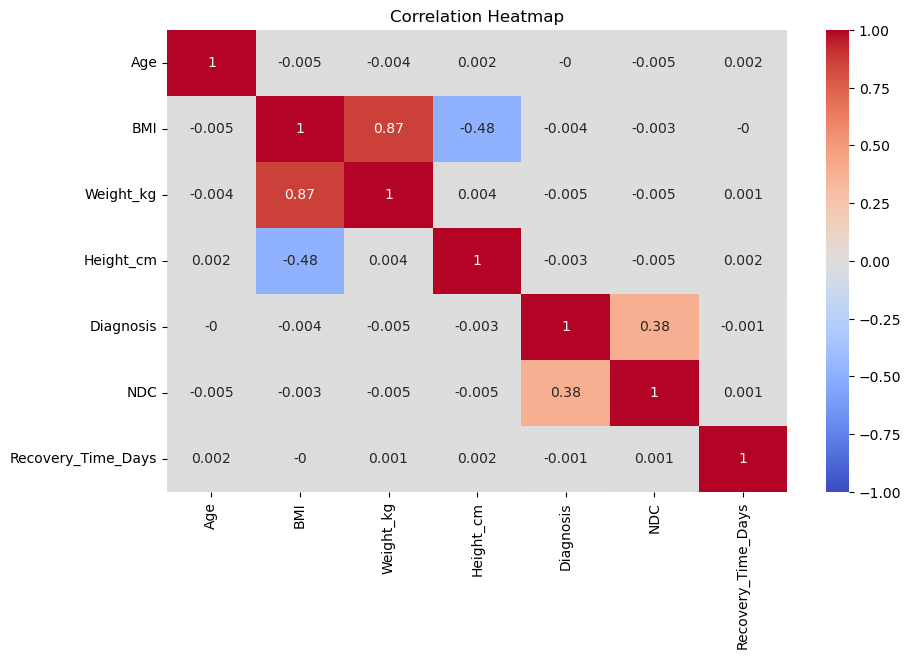

In [16]:
df_numeric = df.select_dtypes(include=['int64','float64'])
plt.figure(figsize = (10,6))
sns.heatmap(df_numeric.corr().round(3),annot=True,cmap='coolwarm',vmin=-1,vmax=1)
plt.title('Correlation Heatmap')
plt.show()

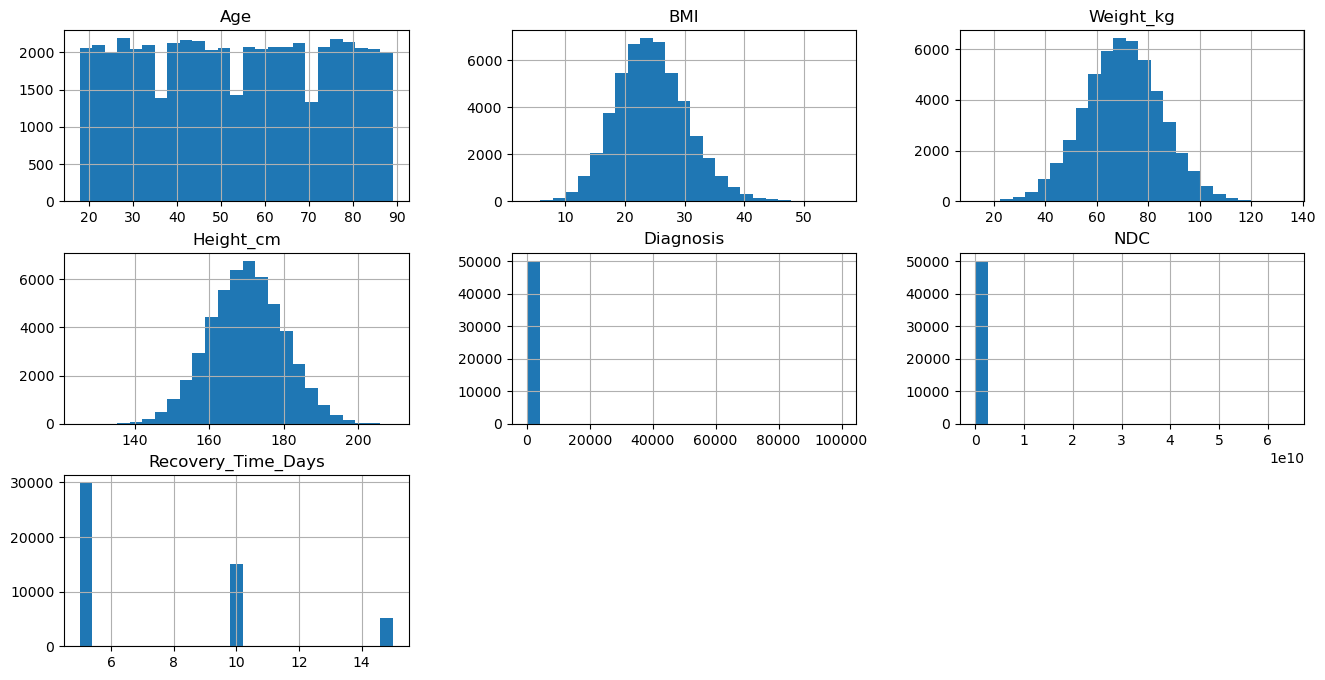

In [17]:
df_numeric.hist(bins=25,figsize=(16,8))
plt.show()

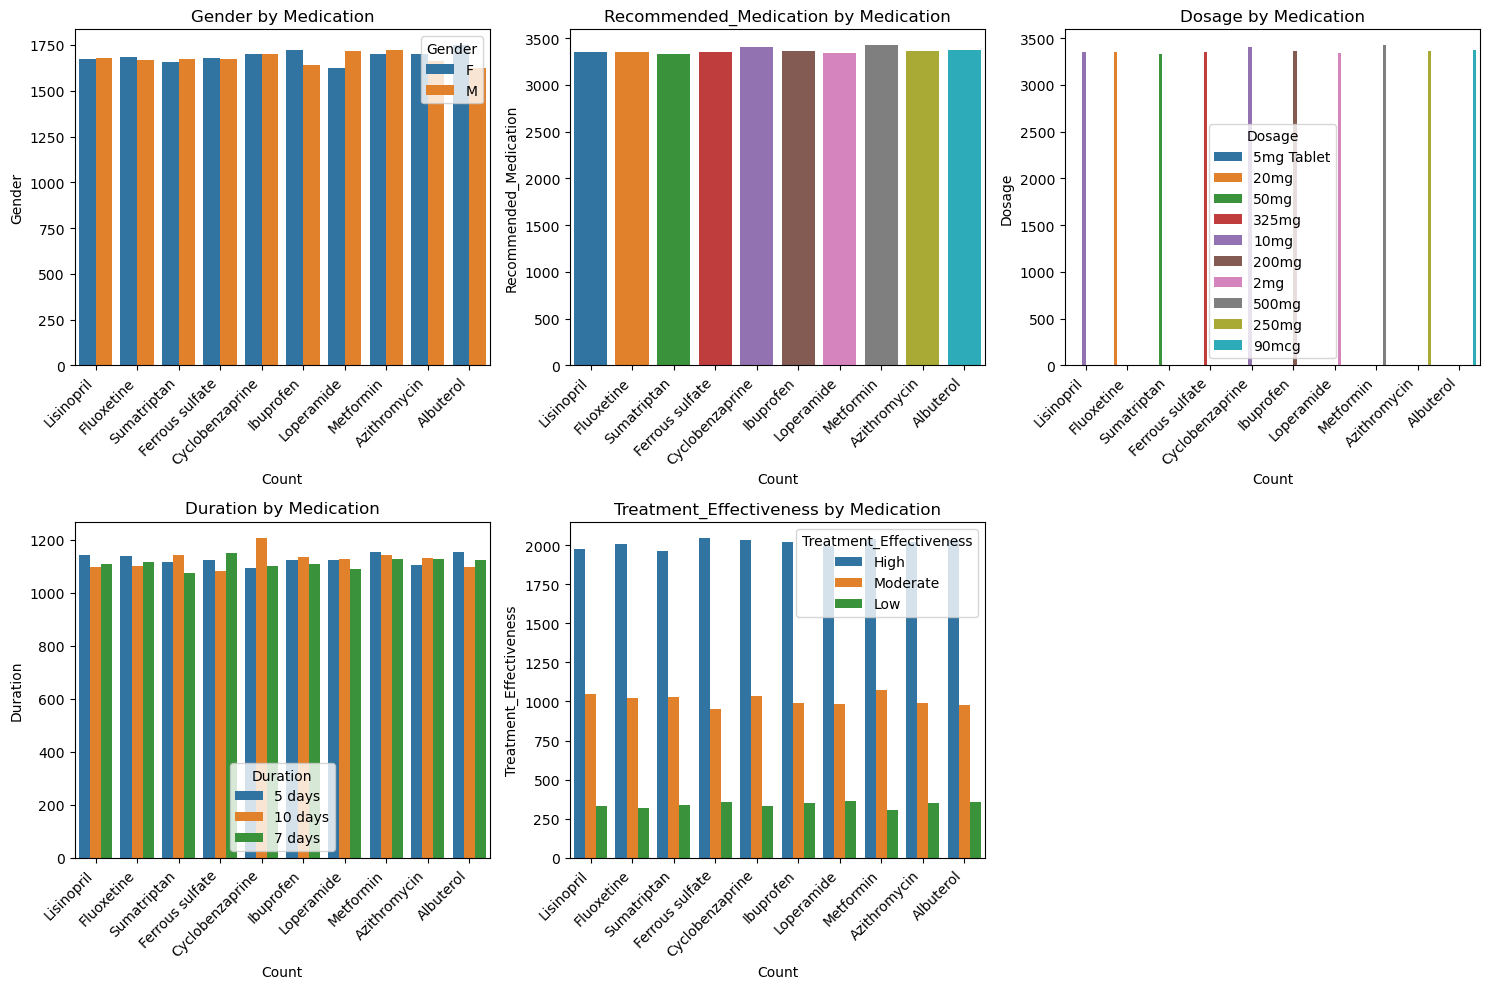

In [18]:
#Analyze categorical columns 

df_category=df.select_dtypes(include=['object']).applymap(lambda x: ', '.join(x) if isinstance(x, list) else x)


df_exploded = df_category.explode('Symptoms')
df_exploded['Symptoms'] = df_exploded['Symptoms'].astype(str)
df_exploded = df_exploded.applymap(lambda x: ', '.join(x) if isinstance(x, list) else x)

top_meds = df_exploded['Recommended_Medication'].value_counts().index[:10]
df_top = df_exploded[df_exploded['Recommended_Medication'].isin(top_meds)].copy()

top_5_cat_cols = [col for col in df_top.select_dtypes(include=['object']).columns if 2 <= df_top[col].nunique() <= 10][:5]


fig, axes = plt.subplots(2, 3, figsize=(15, 10),squeeze=True)
axes = axes.flatten()
for i, col in enumerate(top_5_cat_cols):
    sns.countplot(data=df_top, x='Recommended_Medication',hue=col, ax=axes[i])
    axes[i].set_title(f"{col} by Medication")
    axes[i].set_xlabel("Count")
    axes[i].set_ylabel(col)
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(3, 1), loc='upper right')
# Remove unused axes
for j in range(len(top_5_cat_cols), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

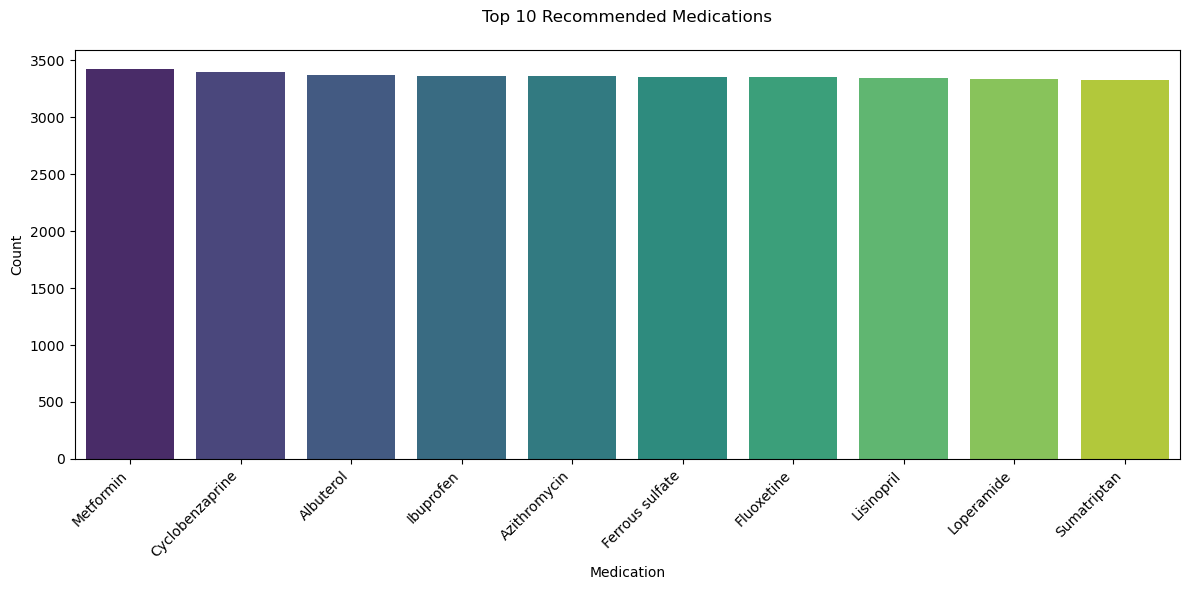

In [19]:

top_meds_counts = df['Recommended_Medication'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_meds_counts.index, y=top_meds_counts.values, palette="viridis")

plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Recommended Medications", pad=20)
plt.xlabel("Medication")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [20]:
#Function to get medication by condition
def get_medication_for_symptoms(condition):
    def condition_matcher(x):
        if isinstance(x, list):
            return any(condition.lower() in s.lower() for s in x)
        elif isinstance(x, str):
            return condition.lower() in x.lower()
        return False

    matched_rows = df[df['Chronic_Conditions'].apply(condition_matcher)]
    
    if matched_rows.empty:
        print(f"No matches found for condition: '{condition}'")
        return []

    medications = matched_rows['Recommended_Medication'].explode().dropna().unique()
    print(f"Medications for condition '{condition}':\n", medications)
    return 


In [21]:
get_medication_for_symptoms('Headache')

Medications for condition 'Headache':
 ['Pantoprazole' 'Sumatriptan']


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50094 entries, 0 to 50093
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      50094 non-null  int64  
 1   Gender                   50094 non-null  object 
 2   BMI                      50094 non-null  float64
 3   Weight_kg                50094 non-null  float64
 4   Height_cm                50094 non-null  float64
 5   Chronic_Conditions       50094 non-null  object 
 6   Symptoms                 50094 non-null  object 
 7   Diagnosis                50094 non-null  float64
 8   Recommended_Medication   50083 non-null  object 
 9   NDC                      50094 non-null  int64  
 10  Dosage                   50094 non-null  object 
 11  Duration                 50094 non-null  object 
 12  Treatment_Effectiveness  50094 non-null  object 
 13  Recovery_Time_Days       50094 non-null  int64  
dtypes: float64(4), int64(3

#Feature Engineering


In [24]:
#convert text in symptom and chronic condition columns using countvectorizer
from sklearn.feature_extraction.text import CountVectorizer

def prepare_text_column(column):
    
    def normalize(x):
        if isinstance(x, list):
            return ' '.join(str(i) for i in x)
        elif isinstance(x, str):
            return x
        else:
            return ''
    return column.fillna('').apply(normalize)

In [25]:

#Feature Extraction :convert text in symptom and chronic condition columns using countvectorizer
df['Symptoms_clean'] = prepare_text_column(df['Symptoms'])
df['Chronic_Conditions_clean'] = prepare_text_column(df['Chronic_Conditions'])

# Vectorize Symptoms
symptom_vectorizer = CountVectorizer(binary=True, stop_words='english', max_features=100)
symptom_encoded = symptom_vectorizer.fit_transform(df['Symptoms_clean'])

# Vectorize Chronic Conditions
chronic_vectorizer = CountVectorizer(binary=True, stop_words='english', max_features=100)
chronic_encoded = chronic_vectorizer.fit_transform(df['Chronic_Conditions_clean'])

# Convert to DataFrame
symptom_df = pd.DataFrame(symptom_encoded.toarray(), columns=[f"Symptom_{w}" for w in symptom_vectorizer.get_feature_names_out()])
chronic_df = pd.DataFrame(chronic_encoded.toarray(), columns=[f"Chronic_{w}" for w in chronic_vectorizer.get_feature_names_out()])

# Combine with original DataFrame
df_final = pd.concat([df, symptom_df, chronic_df], axis=1)


In [26]:
#drop rows with NaN values
df_final = df_final.dropna(axis=0)


In [27]:
df_final.sample(10)

Age Gender   BMI  Weight_kg  Height_cm  \
8604    37      F  23.4       65.2      167.1   
41505   85      F  30.4       85.9      168.1   
20842   41      M  24.6       76.3      176.1   
44127   62      M  22.2       75.8      184.6   
28366   85      F  30.1       89.8      172.8   
24874   70      F  28.2       57.6      142.9   
6906    20      M  22.3       55.8      158.3   
5871    19      F  26.4       74.0      167.5   
21996   57      M  24.8       71.0      169.2   
8881    44      M  25.0       81.7      180.9   

                           Chronic_Conditions  \
8604                                   Anemia   
41505                     Depressive disorder   
20842  Gastroesophageal reflux disease (GERD)   
44127                                Diarrhea   
28366                  Essential hypertension   
24874                     Depressive disorder   
6906                                 Insomnia   
5871                                Pneumonia   
21996               Lumbago (lower back pain)   
8881                                    Fever   

                                             Symptoms  Diagnosis  \
8604                         ['Dizziness, Pale skin']     285.90   
41505       ['Persistent sadness, Sleep disturbance']     311.00   
20842  ['Heartburn, Regurgitation, Chest discomfort']     530.81   
44127           ['Loose stools, Urgency to defecate']     787.91   
28366                                   ['Dizziness']     401.90   
24874                 ['Fatigue, Persistent sadness']     311.00   
6906                                 ['Restlessness']     780.52   
5871                                        ['Cough']     486.00   
21996      ['Stiffness, Back pain, Limited movement']     724.20   
8881                   ['Sweating, High temperature']     780.60   

      Recommended_Medication        NDC  ... Chronic_tract  \
8604         Ferrous sulfate    1210649  ...             0   
41505             Fluoxetine     494900  ...             0   
20842             Omeprazole    1730834  ...             0   
44127             Loperamide    5740397  ...             0   
28366             Lisinopril  435470282  ...             0   
24874             Fluoxetine     494900  ...             0   
6906                Zolpidem    2282550  ...             0   
5871            Azithromycin  167140492  ...             0   
21996              Ibuprofen    5271402  ...             0   
8881           Acetaminophen    5910465  ...             0   

      Chronic_transfusion Chronic_transplant  Chronic_unstable Chronic_upper  \
8604                    0                  0                 0             0   
41505                   0                  0                 0             0   
20842                   0                  0                 0             0   
44127                   0                  0                 0             0   
28366                   0                  0                 0             0   
24874                   0                  0                 0             0   
6906                    0                  0                 0             0   
5871                    0                  0                 0             0   
21996                   0                  0                 0             0   
8881                    0                  0                 0             0   

      Chronic_urinary  Chronic_valve  Chronic_variceal  Chronic_vehicle  \
8604                0              0                 0                0   
41505               0              0                 0                0   
20842               0              0                 0                0   
44127               0              0                 0                0   
28366               0              0                 0                0   
24874               0              0                 0                0   
6906                0              0                 0                0   
5871          

In [28]:
#Feature Engineering: Encoding and impute features 

ONEHOT_FEATURES = ['Gender', 'Duration','Dosage']
ORDINAL_FEATURE = ['Treatment_Effectiveness']
NUMERICAL_FEATURES = ['Age','Weight_kg','Height_cm','BMI','Diagnosis','NDC']

#Creating a preprocessor
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

numeric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent', fill_value='missing')),
     ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
   
])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, NUMERICAL_FEATURES),
        ('cat', categorical_transformer, ONEHOT_FEATURES),
        ('ord', ordinal_transformer,ORDINAL_FEATURE),
       
    ]
)


In [29]:
FEATURES = NUMERICAL_FEATURES + ONEHOT_FEATURES+ORDINAL_FEATURE+symptom_df.columns.tolist()+chronic_df.columns.tolist()
df_final[FEATURES]

Age  Weight_kg  Height_cm   BMI  Diagnosis          NDC Gender  \
0       37       71.8      167.8  25.5   99591.00  51079081120      F   
1       58       82.2      188.8  23.1     389.00     74610204      F   
2       76       48.4      156.4  19.8   81201.00     74131230      F   
3       51       84.0      167.7  29.9     389.00    310030011      M   
4       22       51.8      159.4  20.4     431.00  55390007310      F   
...    ...        ...        ...   ...        ...          ...    ...   
50089   23       73.6      159.7  28.9     311.00       494900      F   
50090   88       75.6      159.3  29.8     787.01      1730601      M   
50091   20       74.9      174.7  24.5     724.20      5271402      M   
50092   43       37.5      157.2  15.2     784.00       245910      M   
50093   69       71.8      190.4  19.8     493.90       748038      M   

      Duration             Dosage Treatment_Effectiveness  ...  Chronic_tract  \
0       5 days           10MG TAB                    High  ...              0   
1      14 days      40MG/4ML VIAL                    High  ...              0   
2       5 days     2mg/mL Syringe                Moderate  ...              0   
3      10 days  1000mg/100mL Vial                Moderate  ...              0   
4       7 days       5mg/5mL Vial                Moderate  ...              0   
...        ...                ...                     ...  ...            ...   
50089   7 days               20mg                    High  ...              0   
50090  10 days                4mg                    High  ...              0   
50091   7 days              200mg                Moderate  ...              0   
50092  10 days               50mg                    High  ...              0   
50093   5 days              90mcg                Moderate  ...              0   

       Chronic_transfusion  Chronic_transplant  Chronic_unstable  \
0                        0                   0                 0   
1                        0                   0                 0   
2                        0                   0                 0   
3                        0                   0                 0   
4                        0                   0                 0   
...                    ...                 ...               ...   
50089                    0                   0                 0   
50090                    0                   0                 0   
50091                    0                   0                 0   
50092                    0                   0                 0   
50093                    0                   0                 0   

       Chronic_upper  Chronic_urinary  Chronic_valve  Chronic_variceal  \
0                  0                0              0                 0   
1                  0                0              0                 0   
2                  0                0              0                 0   
3                  0                0              0                 0   
4                  0                0              0                 0   
...              ...              ...            ...               ...   
50089              0                0              0                 0   
50090              0                0              0                 0   
50091              0                0              0                 0   
50092              0                0              0                 0   
50093              0                0              0                 0   

       Chronic_vehicle  Chronic_vomiting  
0                    0                 0  
1                    0                 0  
2                    0                 0  
3                    0                 0  
4                    0                 0  
...                ...               ...  
50089                0                 0  
50090                0                 1  
50091                0                 0  
50092                

In [98]:
# Count the number of samples per class
class_counts = df_final['Recommended_Medication'].value_counts()

# Keep only classes with at least 2 samples
valid_classes = class_counts[class_counts >= 2].index
df_filtered = df_final[df_final['Recommended_Medication'].isin(valid_classes)]
df_filtered

FEATURES = NUMERICAL_FEATURES + ONEHOT_FEATURES+ORDINAL_FEATURE+symptom_df.columns.tolist()+chronic_df.columns.tolist()
X = df_filtered[FEATURES]

df_filtered['Recommended_Medication']= df_filtered['Recommended_Medication'].astype(str)
df_filtered['Recommended_Medication_list'] = df_filtered['Recommended_Medication'].apply(lambda x: [med.strip() for med in x.split(',')])
y = df_filtered['Recommended_Medication_list']

In [38]:
print(X.isnull().sum().sum(), y.isnull().sum())

0 0


In [100]:
#split to train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(f"Training set size: {X_train.shape}. Training labels size: {y_train.shape}")
print(f"Test set size: {X_test.shape}. Test labels size: {y_test.shape}")


Training set size: (33532, 210). Training labels size: (33532,)
Test set size: (16516, 210). Test labels size: (16516,)


In [102]:
y_train.sample(10)

16290      [Acetaminophen]
10966        [Sumatriptan]
46385         [Fluoxetine]
29734         [Omeprazole]
1700           [Albuterol]
9346     [Cyclobenzaprine]
26265      [Acetaminophen]
16817         [Fluoxetine]
3512          [Omeprazole]
35777    [Cyclobenzaprine]
Name: Recommended_Medication_list, dtype: object

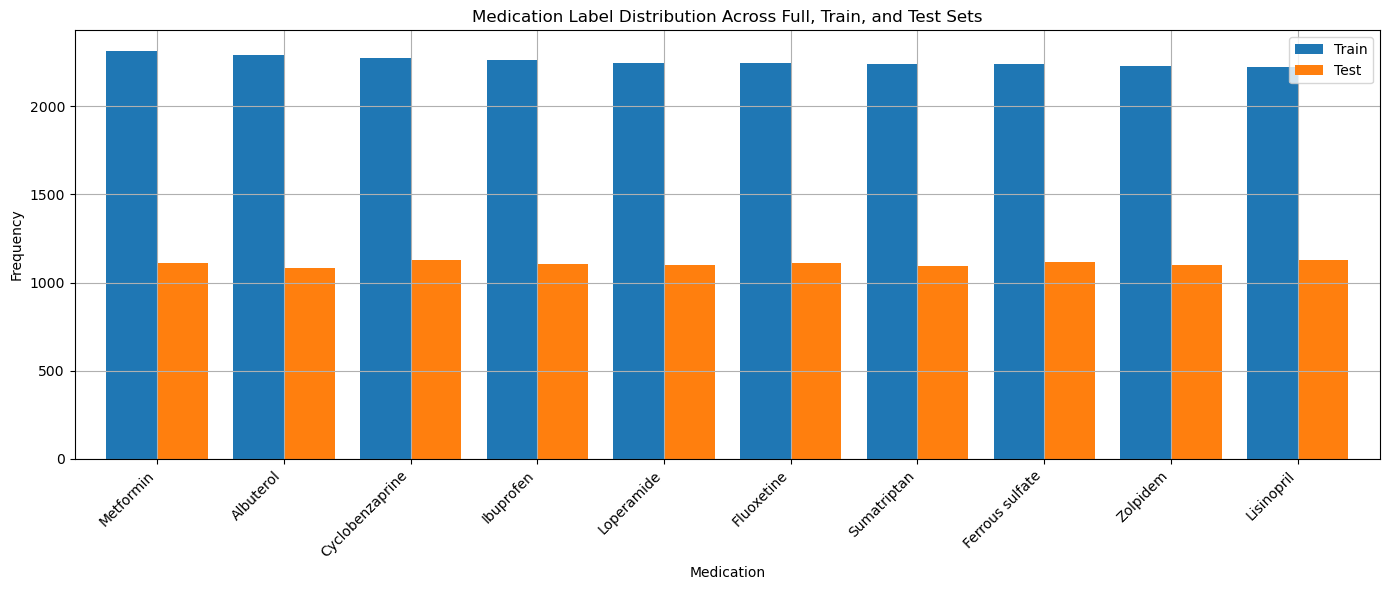

In [264]:
#Medication distribution between train and test set
mlb = MultiLabelBinarizer()

y_train_encoded = mlb.fit_transform(y_train)
y_test_encoded = mlb.transform(y_test)


y_train_df = pd.DataFrame(y_train_encoded,columns=mlb.classes_)
y_test_df = pd.DataFrame(y_test_encoded,columns=mlb.classes_)

# Step 2: Get label frequencies (i.e., how often each medication appears)

train_dist = y_train_df.sum()
test_dist = y_test_df.sum()

top_n = 10
top_medications = train_dist.sort_values(ascending=False).head(top_n).index.tolist()

# Step 4: Slice the top meds

train_top = train_dist[top_medications]
test_top = test_dist[top_medications]

# Step 5: Combine for plotting
distribution_df = pd.DataFrame({
    'Train': train_top,
    'Test': test_top
})

# Step 4: Plot
distribution_df.plot(kind='bar', figsize=(14, 6), width=0.8)
plt.title("Medication Label Distribution Across Full, Train, and Test Sets")
plt.xlabel("Medication")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()

In [266]:
train_top

Metformin          2314
Albuterol          2291
Cyclobenzaprine    2275
Ibuprofen          2261
Loperamide         2242
Fluoxetine         2242
Sumatriptan        2237
Ferrous sulfate    2237
Zolpidem           2227
Lisinopril         2224
dtype: int64

In [107]:
y_train_df.head(10)

Acetaminophen  Albuterol  Azithromycin  Cyclobenzaprine  Ferrous sulfate  \
0              0          0             0                0                0   
1              0          0             0                0                0   
2              0          0             0                0                0   
3              1          0             0                0                0   
4              0          0             0                0                0   
5              0          0             0                0                0   
6              0          0             1                0                0   
7              0          0             0                1                0   
8              0          0             0                0                0   
9              0          0             1                0                0   

   Fluoxetine  Furosemide  Heparin  Ibuprofen  Influenza  ...  Multivitamins  \
0           0           0        0          0          0  ...              0   
1           0           0        0          0          0  ...              0   
2           0           0        0          0          0  ...              0   
3           0           0        0          0          0  ...              0   
4           1           0        0          0          0  ...              0   
5           0           0        0          0          0  ...              0   
6           0           0        0          0          0  ...              0   
7           0           0        0          0          0  ...              0   
8           0           0        0          0          0  ...              0   
9           0           0        0          0          0  ...              0   

   Nitrofurantoin  Omeprazole  Ondansetron  Polyvalent  Sumatriptan  Vac  \
0               0           1            0           0            0    0   
1               0           0            1           0            0    0   
2               0           0            0           0            0    0   
3               0           0            0           0            0    0   
4               0           0            0           0            0    0   
5               0           0            0           0            0    0   
6               0           0            0           0            0    0   
7               0           0            0           0            0    0   
8               1           0            0           0            0    0   
9               0           0            0           0            0    0   

   Vaccine  Virus  Zolpidem  
0        0      0         0  
1        0      0         0  
2        0      0         0  
3        0      0         0  
4        0      0         0  
5        0      0         1  
6        0      0         0  
7        0      0         0  
8        0      0         0  
9        0      0         0  

[10 rows x 25 columns]

In [109]:
#Preprocess all features , since symptom and chronic conditions have been vectorized,
# these columns are included post preprocessing other columns
CORE_FEATURES = NUMERICAL_FEATURES + ONEHOT_FEATURES + ORDINAL_FEATURE
SYMPTOM_FEATURES = symptom_df.columns.tolist()
CHRONIC_FEATURES = chronic_df.columns.tolist()

X_train_core = preprocessor.fit_transform(X_train[CORE_FEATURES])
X_test_core = preprocessor.transform(X_test[CORE_FEATURES])

X_train_cc = X_train[SYMPTOM_FEATURES + CHRONIC_FEATURES].values
X_test_cc = X_test[SYMPTOM_FEATURES + CHRONIC_FEATURES].values

X_train_final = np.concatenate([X_train_core, X_train_cc], axis=1)
X_test_final = np.concatenate([X_test_core, X_test_cc], axis=1)

numerical_column_names = NUMERICAL_FEATURES

ordinal_column_names = preprocessor.named_transformers_['ord'].get_feature_names_out(ORDINAL_FEATURE)

# The method get_feature_names_out generates the names of the new columns created by OneHotEncoder for the categorical columns
onehot_column_names = preprocessor.named_transformers_['cat'].get_feature_names_out(ONEHOT_FEATURES)

# Combine the names of numerical and all other feature columns into a single list
all_column_names = list(numerical_column_names) +list(onehot_column_names)+list(ordinal_column_names)+SYMPTOM_FEATURES+CHRONIC_FEATURES



In [56]:
X_train_final

array([[-0.49713822,  0.28240276, -1.32416251, ...,  0.        ,
         0.        ,  1.        ],
       [-1.27082229,  1.08022143,  0.20703851, ...,  0.        ,
         0.        ,  0.        ],
       [-0.11029618,  0.92730618,  1.107745  , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.88398026,  0.76109396, -1.7044608 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.65766433, -0.90767676, -0.32337753, ...,  0.        ,
         0.        ,  0.        ],
       [-0.20700669, -0.84119187, -0.24331473, ...,  0.        ,
         0.        ,  0.        ]])

In [258]:
# Convert the matrix into a DataFrame with the column names for train
X_train_processed_df = pd.DataFrame(X_train_final, columns=all_column_names)

X_train_processed_df


Age  Weight_kg  Height_cm       BMI  Diagnosis       NDC  \
0     -0.889438   0.523172   1.587459 -0.330749  -0.060881 -0.054048   
1      1.667391  -0.532938  -1.904543  0.449781   0.136359 -0.054048   
2      1.233212  -1.669260  -2.604944 -0.463606  -0.160125  0.302287   
3      1.088486   0.402856   1.527424 -0.380570   0.131424 -0.050615   
4     -0.117565   1.178228   0.576880  0.649065  -0.230107 -0.055064   
...         ...        ...        ...       ...        ...       ...   
33527 -0.503502  -1.221416   0.236685 -1.177708   0.131424 -0.050615   
33528  1.667391  -0.258884  -0.073493 -0.231107   0.134042 -0.055268   
33529  1.667391   1.245070   1.077166  0.433174  -0.089297 -0.054856   
33530 -1.468343   2.287812  -1.564348  3.206548   0.137052 -0.050754   
33531 -0.455260   0.696962  -0.063487  0.599244   0.136359 -0.054048   

       Gender_F  Gender_M  Duration_10 days  Duration_14 days  ...  \
0           0.0       1.0               0.0               0.0  ...   
1           1.0       0.0               0.0               0.0  ...   
2           0.0       1.0               1.0               0.0  ...   
3           1.0       0.0               0.0               0.0  ...   
4           1.0       0.0               1.0               0.0  ...   
...         ...       ...               ...               ...  ...   
33527       0.0       1.0               0.0               0.0  ...   
33528       0.0       1.0               1.0               0.0  ...   
33529       0.0       1.0               0.0               0.0  ...   
33530       1.0       0.0               1.0               0.0  ...   
33531       1.0       0.0               0.0               0.0  ...   

       Chronic_tract  Chronic_transfusion  Chronic_transplant  \
0                0.0                  0.0                 0.0   
1                0.0                  0.0                 0.0   
2                0.0                  0.0                 0.0   
3                0.0                  0.0                 0.0   
4                0.0                  0.0                 0.0   
...              ...                  ...                 ...   
33527            0.0                  0.0                 0.0   
33528            0.0                  0.0                 0.0   
33529            0.0                  0.0                 0.0   
33530            0.0                  0.0                 0.0   
33531            0.0                  0.0                 0.0   

       Chronic_unstable  Chronic_upper  Chronic_urinary  Chronic_valve  \
0                   0.0            0.0              0.0            0.0   
1                   0.0            0.0              0.0            0.0   
2                   0.0            0.0              0.0            0.0   
3                   0.0            0.0              0.0            0.0   
4                   0.0            0.0              0.0            0.0   
...                 ...            ...              ...            ...   
33527               0.0            0.0              0.0            0.0   
33528               0.0            0.0              0.0            0.0   
33529               0.0            0.0              0.0            0.0   
33530               0.0            0.0              0.0            0.0   
33531               0.0            0.0              0.0            0.0   

       Chronic_variceal  Chronic_vehicle  Chronic_vomiting  
0                   0.0              0.0               0.0  
1                   0.0              0.0               1.0  
2                   0.0              0.0               0.0  
3                   0.0              0.0               0.0  
4                   0.0              0.0               0.0  
...                 ...              ...               ...  
33527               0.0              0.0               0.0  
33528               0.0              0.0               0.0  
33529               0.0              0.0               0.0  
33530               0.0   

In [113]:
#Convert the matrix into a DataFrame with the column names for test
X_test_processed_df = pd.DataFrame(X_test_final, columns=all_column_names)

X_test_processed_df.head()

Age  Weight_kg  Height_cm       BMI  Diagnosis       NDC  Gender_F  \
0 -1.130648   0.429593   2.798153 -0.828960   0.088004 -0.051140       1.0   
1 -0.021081   0.442961  -1.724439  1.396382  -0.160125  0.302287       0.0   
2 -0.358775  -0.085094  -0.123522 -0.065037   0.134042 -0.055268       0.0   
3  0.461340  -0.526254   1.327310 -0.995031   0.131363 -0.053595       1.0   
4 -1.516585   0.309276   0.016558  0.217283  -0.008384 -0.054705       0.0   

   Gender_M  Duration_10 days  Duration_14 days  ...  Chronic_tract  \
0       0.0               0.0               0.0  ...            0.0   
1       1.0               0.0               0.0  ...            0.0   
2       1.0               0.0               0.0  ...            0.0   
3       0.0               0.0               0.0  ...            0.0   
4       1.0               0.0               0.0  ...            1.0   

   Chronic_transfusion  Chronic_transplant  Chronic_unstable  Chronic_upper  \
0                  0.0                 0.0               0.0            0.0   
1                  0.0                 0.0               0.0            0.0   
2                  0.0                 0.0               0.0            0.0   
3                  0.0                 0.0               0.0            0.0   
4                  0.0                 0.0               0.0            0.0   

   Chronic_urinary  Chronic_valve  Chronic_variceal  Chronic_vehicle  \
0              0.0            0.0               0.0              0.0   
1              0.0            0.0               0.0              0.0   
2              0.0            0.0               0.0              0.0   
3              0.0            0.0               0.0              0.0   
4              1.0            0.0               0.0              0.0   

   Chronic_vomiting  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  

[5 rows x 240 columns]

In [115]:
y_train_df

Acetaminophen  Albuterol  Azithromycin  Cyclobenzaprine  \
0                  0          0             0                0   
1                  0          0             0                0   
2                  0          0             0                0   
3                  1          0             0                0   
4                  0          0             0                0   
...              ...        ...           ...              ...   
33527              1          0             0                0   
33528              0          0             0                0   
33529              0          1             0                0   
33530              0          0             0                0   
33531              0          0             0                0   

       Ferrous sulfate  Fluoxetine  Furosemide  Heparin  Ibuprofen  Influenza  \
0                    0           0           0        0          0          0   
1                    0           0           0        0          0          0   
2                    0           0           0        0          0          0   
3                    0           0           0        0          0          0   
4                    0           1           0        0          0          0   
...                ...         ...         ...      ...        ...        ...   
33527                0           0           0        0          0          0   
33528                0           0           0        0          0          0   
33529                0           0           0        0          0          0   
33530                0           0           0        0          0          0   
33531                0           0           0        0          0          0   

       ...  Multivitamins  Nitrofurantoin  Omeprazole  Ondansetron  \
0      ...              0               0           1            0   
1      ...              0               0           0            1   
2      ...              0               0           0            0   
3      ...              0               0           0            0   
4      ...              0               0           0            0   
...    ...            ...             ...         ...          ...   
33527  ...              0               0           0            0   
33528  ...              0               0           0            0   
33529  ...              0               0           0            0   
33530  ...              0               0           0            0   
33531  ...              0               0           0            1   

       Polyvalent  Sumatriptan  Vac  Vaccine  Virus  Zolpidem  
0               0            0    0        0      0         0  
1               0            0    0        0      0         0  
2               0            0    0        0      0         0  
3               0            0    0        0      0         0  
4               0            0    0        0      0         0  
...           ...          ...  ...      ...    ...       ...  
33527           0            0    0        0      0         0  
33528           0            1    0        0      0         0  
33529           0            0    0        0      0         0  
33530           0            0    0        0      0         0  
33531           0            0    0        0      0         0  

[33532 rows x 25 columns]

In [117]:

baseline = MultiOutputClassifier(DummyClassifier(strategy="stratified"))
baseline.fit(X_train_processed_df, y_train_df)
y_pred_baseline = baseline.predict(X_test_processed_df)

print("Baseline Accuracy:", accuracy_score(y_test_df, y_pred_baseline))
print("Baseline F1 Score:", f1_score(y_test_df, y_pred_baseline, average='weighted'))
# y_mean_pred = np.full_like(y_test,y_train.mean())
# rmse_baseline = np.sqrt(mean_squared_error(y_test,y_mean_pred))
# r2_baseline = r2_score(y_test,y_mean_pred)

# print(f"Baseline RMSE:{rmse_baseline}")
# print(f"Baseline R^2:{r2_baseline}")
                        

Baseline Accuracy: 0.025672075563090337
Baseline F1 Score: 0.06671387839819111


In [119]:
#baseline prediction before balancing and resampling
random_baseline_before = MultiOutputClassifier(DummyClassifier(strategy="stratified")) # most_frequent for majority guess
random_baseline_before.fit(X_train_processed_df, y_train_df)
y_random_pred_bfr = random_baseline_before.predict(X_test_processed_df)
#baseline metrics calculation before resampling
accuracy_baseline_bfr = accuracy_score(y_test_df, y_random_pred_bfr)
precision_baseline_bfr = precision_score(y_test_df, y_random_pred_bfr, average='weighted', zero_division=0)
recall_baseline_bfr = recall_score(y_test_df, y_random_pred_bfr, average='weighted', zero_division=0)
f1_baseline_bfr = f1_score(y_test_df, y_random_pred_bfr, average='weighted', zero_division=0)
cm_bfr = multilabel_confusion_matrix(y_test_df, y_random_pred_bfr)

print(f"Baseline Accuracy: {accuracy_baseline_bfr:.2f}")
print(f"Baseline Precision: {precision_baseline_bfr:.2f}")
print(f"Baseline Recall: {recall_baseline_bfr:.2f}")
print(f"Baseline F1 Score: {f1_baseline_bfr:.2f}")



Baseline Accuracy: 0.03
Baseline Precision: 0.07
Baseline Recall: 0.07
Baseline F1 Score: 0.07


In [123]:
print(y_test_df.nunique())

Acetaminophen      2
Albuterol          2
Azithromycin       2
Cyclobenzaprine    2
Ferrous sulfate    2
Fluoxetine         2
Furosemide         2
Heparin            2
Ibuprofen          2
Influenza          2
Insulin            1
Lisinopril         2
Loperamide         2
Metformin          2
Metoprolol         2
Multivitamins      2
Nitrofurantoin     2
Omeprazole         2
Ondansetron        2
Polyvalent         2
Sumatriptan        2
Vac                2
Vaccine            2
Virus              2
Zolpidem           2
dtype: int64


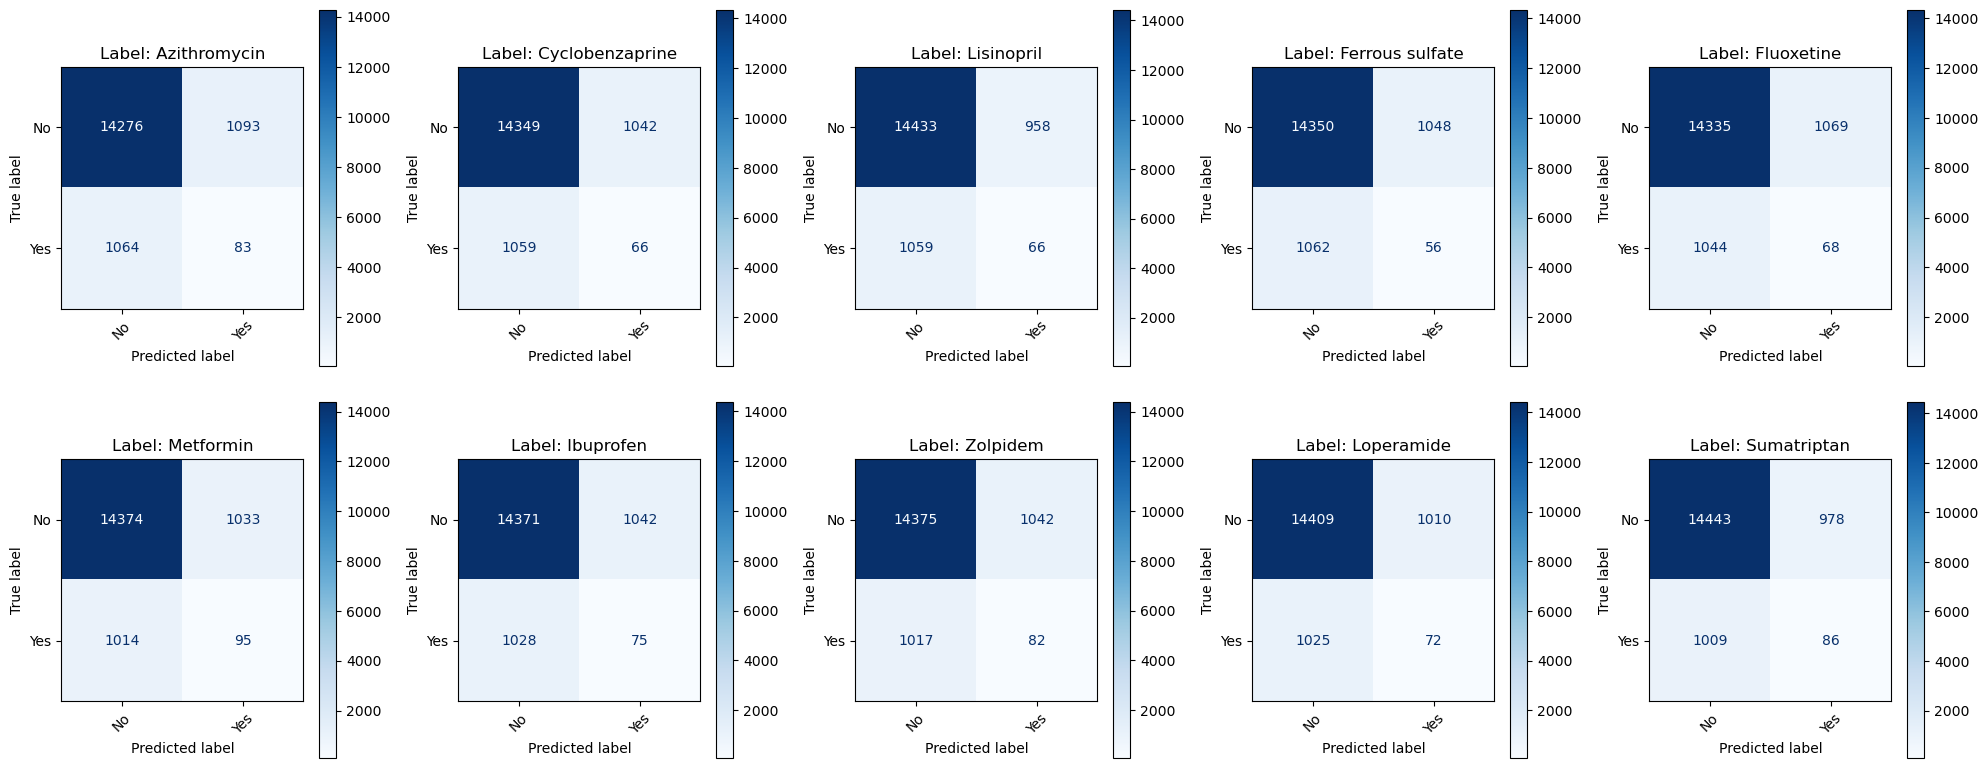

In [135]:
top_n = 10
label_sums = y_test_df.sum(axis=0)
top_labels = label_sums.sort_values(ascending=False).head(top_n).index.tolist()

# Filter confusion matrices and class names
label_indices = [list(mlb.classes_).index(label) for label in top_labels]
top_cm = cm_bfr[label_indices]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, (cm, label) in enumerate(zip(top_cm, top_labels)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    disp.plot(ax=axes[i], cmap="Blues", values_format='d')
    axes[i].set_title(f"Label: {label}")
    axes[i].tick_params(axis='x', rotation=45)

# Hide unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [143]:
df_filtered[col].value_counts(normalize=True).head(10) * 100

Treatment_Effectiveness
High        59.580802
Moderate    30.216992
Low         10.202206
Name: proportion, dtype: float64

In [276]:
# Set up plotting grid after preprocessing
n_cols = 3
n_rows = -(-len(CORE_FEATURES+SYMPTOM_FEATURES+CHRONIC_FEATURES) // n_cols)  # ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

# Loop through each categorical feature
for i, col in enumerate(CORE_FEATURES+SYMPTOM_FEATURES+CHRONIC_FEATURES):
    value_counts = df_filtered[col].value_counts(normalize=True).head(10) * 100  # limit to top 10
    sns.barplot(y=value_counts.index, x=value_counts.values, ax=axes[i], palette='coolwarm')
    axes[i].set_title(f"{col} (Top 10)")
    axes[i].set_xlabel("Percentage")
    axes[i].set_ylabel("")
    axes[i].tick_params(axis='x', rotation=45)
# Hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Categorical Features", fontsize=16, y=1.01)
plt.show()

In [278]:
np.unique(y_test_df)

array([0, 1])

In [149]:
#Simple model train
lgr_model = MultiOutputClassifier(LogisticRegression(max_iter=1000, random_state=42))
lgr_model.fit(X_train_processed_df,y_train_df)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000,
                                                   random_state=42))

In [151]:
y_pred_lgr = lgr_model.predict(X_test_processed_df)

train_accuracy = lgr_model.score(X_train_processed_df,y_train_df)
test_accuracy = accuracy_score(y_test_df,y_pred_lgr)

print(f"Logistic Regression Training Accuracy: {train_accuracy:.2f}")
print(f"Logistic Regression Test Accuracy: {test_accuracy:.2f}")
print("\n Classification report:")
print(classification_report(y_test_df,y_pred_lgr))

Logistic Regression Training Accuracy: 1.00
Logistic Regression Test Accuracy: 1.00

 Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1093
           1       1.00      1.00      1.00      1083
           2       1.00      1.00      1.00      1147
           3       1.00      1.00      1.00      1125
           4       1.00      1.00      1.00      1118
           5       1.00      1.00      1.00      1112
           6       0.00      0.00      0.00         1
           7       0.50      0.50      0.50         2
           8       1.00      1.00      1.00      1103
           9       0.50      0.33      0.40         3
          10       0.00      0.00      0.00         0
          11       1.00      1.00      1.00      1125
          12       1.00      1.00      1.00      1097
          13       1.00      1.00      1.00      1109
          14       0.00      0.00      0.00         1
          15       0.00   

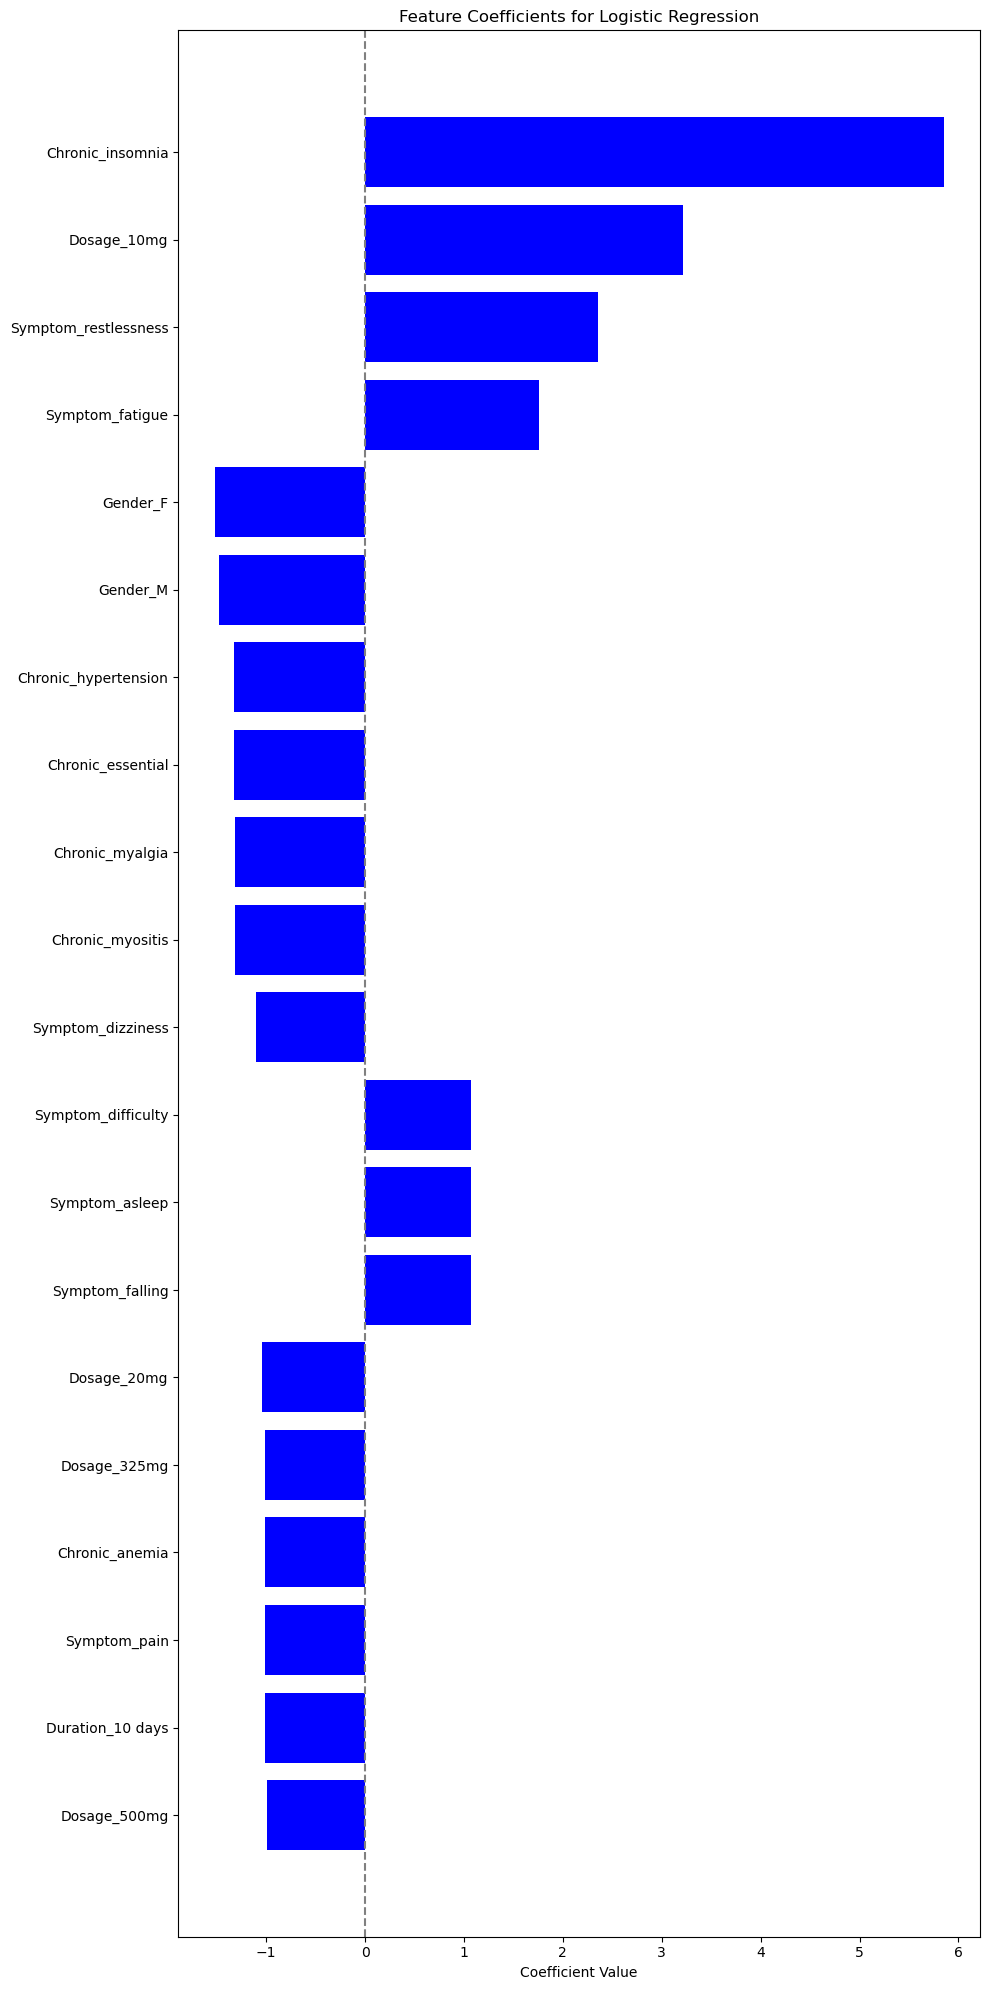

In [280]:
# coefficients =lgr_model.coef_[0]  # Get coefficients
feature_names = X_train_processed_df.columns
n_labels = len(y_train_df.columns)
n_cols = 2
n_rows = (n_labels + 1) // n_cols

for i, clf in enumerate(lgr_model.estimators_):
    label = y_train_df.columns[i]
    coefs = clf.coef_[0]  # shape: (1, n_features)
    
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefs
    }).sort_values(by='Coefficient', key=abs, ascending=False).head(20)

# # Plot the coefficients
plt.figure(figsize=(10, 20))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='blue')
plt.xlabel('Coefficient Value')


plt.title('Feature Coefficients for Logistic Regression')
# Add vertical line at zero for better reference
plt.axvline(x=0, color='gray', linestyle='--')
plt.gca().invert_yaxis()  # To show the most influential features at the top
plt.tight_layout()
plt.show()

In [155]:
#create list to train models
models_train = {
    'Decision Tree': MultiOutputClassifier(DecisionTreeClassifier(random_state=42)),
    'Random Forest': MultiOutputClassifier(RandomForestClassifier(n_estimators=100, n_jobs=-1,random_state=42,class_weight='balanced')),
    'Naive Bayes Gaussian': MultiOutputClassifier(GaussianNB()),  
    'Bagging (Decision Tree)': MultiOutputClassifier(BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'),n_jobs=-1,
                                                                       n_estimators=10,random_state=42))
}
results_m = []
trained_models = {}

for model_name, model in models_train.items():
    print(f"Training and evaluating {model_name}")

 # Train the model on full training data and predict on the test set
    model.fit(X_train_processed_df, y_train_df)
    y_train_pred = model.predict(X_train_processed_df)
    y_test_pred = model.predict(X_test_processed_df)

    # Store trained model
    trained_models[model_name] = model

    # Compute train metrics
    train_accuracy = accuracy_score(y_train_df, y_train_pred)
    train_precision = precision_score(y_train_df, y_train_pred, average='weighted', zero_division=0)
    train_recall = recall_score(y_train_df, y_train_pred, average='weighted', zero_division=0)
    train_f1 = f1_score(y_train_df, y_train_pred, average='weighted', zero_division=0)

    # Compute test metrics
    test_accuracy = accuracy_score(y_test_df, y_test_pred)
    test_precision = precision_score(y_test_df, y_test_pred, average='weighted', zero_division=0)
    test_recall = recall_score(y_test_df, y_test_pred, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test_df, y_test_pred, average='weighted', zero_division=0)

    # Store results
    results_m.append({
        "Model": model_name,
        "Train Accuracy": train_accuracy,
        "Train Precision": train_precision,
        "Train Recall": train_recall,
        "Train F1": train_f1,
        "Test Accuracy": test_accuracy,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Test F1": test_f1,
    })

Training and evaluating Decision Tree
Training and evaluating Random Forest
Training and evaluating Naive Bayes Gaussian
Training and evaluating Bagging (Decision Tree)


In [157]:
results_df_m = pd.DataFrame(results_m).sort_values(by="Test F1",ascending=False)
print(results_df_m)

                     Model  Train Accuracy  Train Precision  Train Recall  \
0            Decision Tree        1.000000              1.0      1.000000   
3  Bagging (Decision Tree)        0.999881              1.0      0.999881   
2     Naive Bayes Gaussian        1.000000              1.0      1.000000   
1            Random Forest        1.000000              1.0      1.000000   

   Train F1  Test Accuracy  Test Precision  Test Recall   Test F1  
0  1.000000       0.999879        0.999819     0.999879  0.999849  
3  0.999934       0.999576        0.999758     0.999576  0.999657  
2  1.000000       0.999273        0.999677     0.998850  0.999062  
1  1.000000       0.999092        0.998669     0.998487  0.998578  


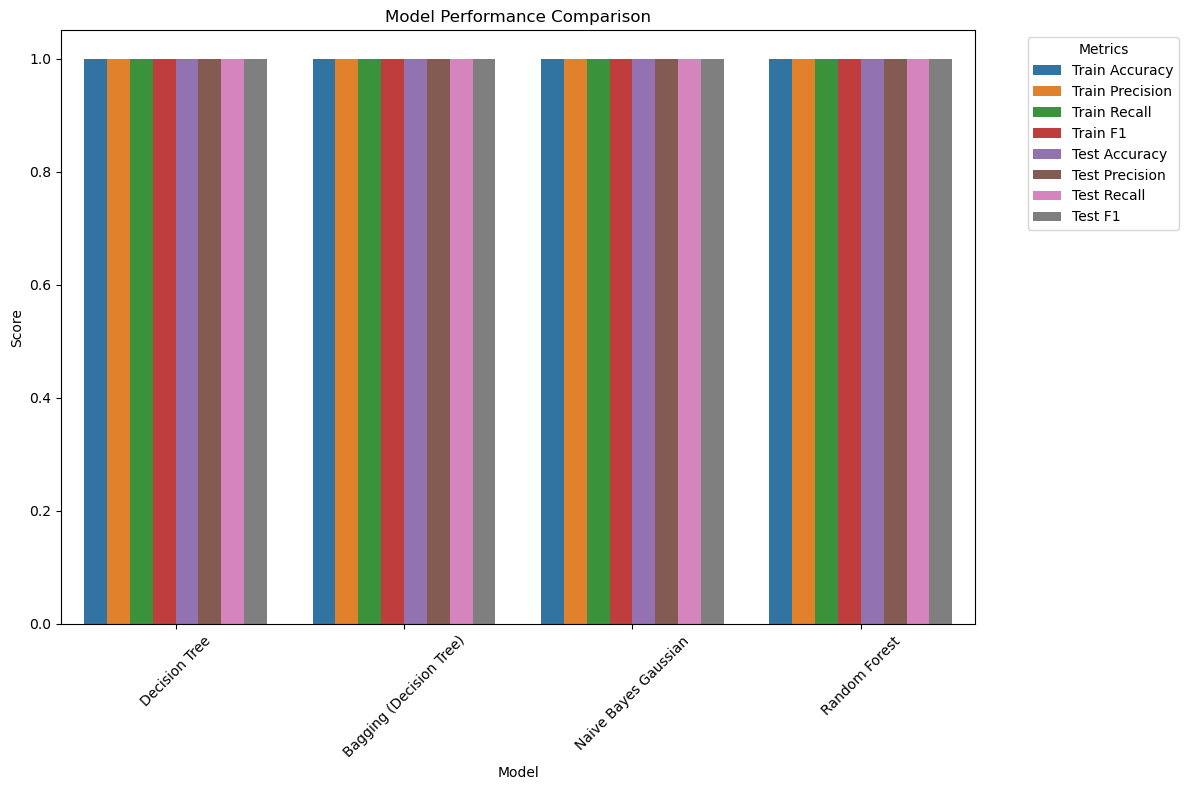

In [159]:
plt.figure(figsize=(12,8))
df_melted = results_df_m.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(x='Model',y='Score', hue='Metric',data=df_melted)
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

Decision Tree:
Train Metrics: Perfect performance (1.0 for all metrics).
Test Metrics: Slightly lower than training performance, but still close to perfect (Test Accuracy = 0.999879, Test Precision = 0.999819).
General Observation: The Decision Tree has excellent performance but shows some slight overfitting due to the small difference in training vs. test scores.
Bagging (Decision Tree):
Train Metrics: Almost perfect (Train Accuracy = 0.999881, Train Precision = 1.0).
Test Metrics: Performance drops a little compared to the Decision Tree, but still very high (Test Accuracy = 0.999576).
General Observation: Bagging improves generalization (compared to a single decision tree), but test performance still slightly lags behind the training performance.
Naive Bayes (Gaussian):
Train Metrics: Perfect performance (Train Accuracy = 1.0, Train Precision = 1.0, etc.).
Test Metrics: Very close to perfect, though recall slightly drops (Test Recall = 0.998850).
General Observation: Naive Bayes appears to generalize very well. However, the performance might slightly degrade in terms of recall compared to the other models.
Random Forest:
Train Metrics: Perfect performance (Train Accuracy = 1.0, Train Precision = 1.0, etc.).
Test Metrics: A slight drop in test performance, particularly in precision and recall, but still quite high (Test Accuracy = 0.999092).
General Observation: Random Forest performs very well and is a strong model with high generalization, although like the other models, there is a slight decrease in test performance compared to training.

In [161]:
#model evaluation on test dataset
results_ev = {}

for model_name, model in models_train.items():
    # Predict on the test set
    y_pred = model.predict(X_test_processed_df)

    # Calculate metrics
    accuracy = accuracy_score(y_test_df, y_pred)
    precision = precision_score(y_test_df, y_pred,average='weighted')
    recall = recall_score(y_test_df, y_pred,average='weighted')
    f1 = f1_score(y_test_df, y_pred,average='weighted')
    # confusion_mat = confusion_matrix(y_test_df, y_pred)

    # Store the results in the dictionary
    results_ev[model_name] = {
        'Accuracy': accuracy,
        'Precision':precision,
        'Recall': recall,
        'F1-Score': f1
        # 'Confusion Matrix': confusion_mat
    }

In [163]:
results_df_ev = pd.DataFrame(results_ev).T.sort_values(by=['Accuracy'],ascending=False)
results_df_ev

Accuracy  Precision    Recall  F1-Score
Decision Tree            0.999879   0.999819  0.999879  0.999849
Bagging (Decision Tree)  0.999576   0.999758  0.999576  0.999657
Naive Bayes Gaussian     0.999273   0.999677  0.998850  0.999062
Random Forest            0.999092   0.998669  0.998487  0.998578

In [165]:

#cross-validation evaluation
results_cv = {}

# Train each model with cross-validation
for model_name, model in models_train.items():
    print(f"Training and evaluating {model_name} with cross-validation...")

    # Perform cross-validation on the training set
    cv_scores = cross_val_score(
        model,
        X_train_processed_df,
        y_train_df,
        scoring='accuracy',
        cv=5,  # 5-fold cross-validation
        n_jobs=-1  # Use all available processors for faster computation
    )

    # Train the model on the full training set
    model.fit(X_train_processed_df, y_train_df)
    y_pred = model.predict(X_test_processed_df)

    trained_models[model_name] = model

    # Store the results in the dictionary
    results_cv[model_name] = {
        'Model': model_name,
        'Cross-Validation Accuracy (mean)': cv_scores.mean(),
        'Cross-Validation Accuracy (std)': cv_scores.std(),
    }

Training and evaluating Decision Tree with cross-validation...
Training and evaluating Random Forest with cross-validation...
Training and evaluating Naive Bayes Gaussian with cross-validation...
Training and evaluating Bagging (Decision Tree) with cross-validation...


In [167]:
results_df = pd.DataFrame(results_cv).T.sort_values('Cross-Validation Accuracy (mean)', ascending=False)
results_df

Model  \
Decision Tree                      Decision Tree   
Bagging (Decision Tree)  Bagging (Decision Tree)   
Naive Bayes Gaussian        Naive Bayes Gaussian   
Random Forest                      Random Forest   

                        Cross-Validation Accuracy (mean)  \
Decision Tree                                   0.999523   
Bagging (Decision Tree)                         0.999433   
Naive Bayes Gaussian                            0.999225   
Random Forest                                   0.999046   

                        Cross-Validation Accuracy (std)  
Decision Tree                                  0.000219  
Bagging (Decision Tree)                        0.000239  
Naive Bayes Gaussian                           0.000382  
Random Forest                                  0.000486

In [ ]:
y_test

In [169]:
# Check the unique classes in y_train (the training set)
print(f"Classes in y_train: {np.unique(y_train)}")
# Check the unique classes in y_test (the test set)
print(f"Classes in y_test: {np.unique(y_test)}")

Classes in y_train: [list(['Acetaminophen']) list(['Albuterol']) list(['Azithromycin'])
 list(['Cyclobenzaprine']) list(['Ferrous sulfate']) list(['Fluoxetine'])
 list(['Furosemide']) list(['Heparin']) list(['Ibuprofen'])
 list(['Influenza', 'Virus', 'Vaccine']) list(['Insulin'])
 list(['Lisinopril']) list(['Loperamide']) list(['Metformin'])
 list(['Metoprolol']) list(['Multivitamins']) list(['Nitrofurantoin'])
 list(['Omeprazole']) list(['Ondansetron']) list(['Sumatriptan'])
 list(['Vac', 'Polyvalent']) list(['Zolpidem'])]
Classes in y_test: [list(['Acetaminophen']) list(['Albuterol']) list(['Azithromycin'])
 list(['Cyclobenzaprine']) list(['Ferrous sulfate']) list(['Fluoxetine'])
 list(['Furosemide']) list(['Heparin']) list(['Ibuprofen'])
 list(['Influenza', 'Virus', 'Vaccine']) list(['Lisinopril'])
 list(['Loperamide']) list(['Metformin']) list(['Metoprolol'])
 list(['Multivitamins']) list(['Nitrofurantoin']) list(['Omeprazole'])
 list(['Ondansetron']) list(['Sumatriptan']) list(['V

In [296]:
X_train_final

array([[-0.88943814,  0.52317205,  1.58745882, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.66739097, -0.53293848, -1.90454262, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.23321244, -1.66925994, -2.60494406, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.66739097,  1.24507039,  1.07716635, ...,  0.        ,
         0.        ,  0.        ],
       [-1.46834284,  2.28781244, -1.56434764, ...,  0.        ,
         0.        ,  0.        ],
       [-0.45525961,  0.69696239, -0.06348742, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
y_train_encoded

In [171]:
#Model Improvement Define models and hyperparameters
models = {
    'knn': (KNeighborsClassifier(), {
        'model__estimator__n_neighbors': [3, 5, 7]
    }),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {
        'model__estimator__max_depth': [5, 10, 15]
    }),
    'randomforestclassifier': (RandomForestClassifier(), {
        'model__estimator__max_depth': [5, 10, 15]
    }),
    'gaussiannb': (GaussianNB(), {}), 
    'baggingclassifier': (BaggingClassifier(), {
        'model__estimator__n_estimators': [10, 50, 100],  # Hyperparameters for Bagging
        'model__estimator__max_samples': [0.5, 1.0]
    })
}
results = []

for name, (model, params) in models.items():
    # Create a pipeline
    print(f"Tuning {name} with GridSearchCV...")
    pipeline = Pipeline([
        
        ('model', MultiOutputClassifier(model))  # Wrap the model in MultiOutputClassifier
    ])
    # print(pipeline)
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=3, n_jobs=-1,verbose=1)
    
    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train_final, y_train_encoded)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    
    # Evaluate on training and test sets
    train_score = best_model.score(X_train_final, y_train_encoded)
    test_score = best_model.score(X_test_final, y_test_encoded)
    
    # Append the results
    results.append([name, train_score, test_score, fit_time])

Tuning knn with GridSearchCV...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Tuning decisiontreeclassifier with GridSearchCV...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Tuning randomforestclassifier with GridSearchCV...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Tuning gaussiannb with GridSearchCV...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Tuning baggingclassifier with GridSearchCV...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [173]:
results_df = pd.DataFrame(results, columns=['Model', 'Train Score', 'Test Score', 'Average Fit Time'])
print(results_df)

                    Model  Train Score  Test Score  Average Fit Time
0                     knn     0.999463    0.999273         33.663452
1  decisiontreeclassifier     1.000000    0.999395          1.247433
2  randomforestclassifier     0.999672    0.999092         11.154746
3              gaussiannb     1.000000    0.999273          2.179850
4       baggingclassifier     1.000000    0.999576         33.971551


In [175]:

models_param = {
    'KNN': (KNeighborsClassifier(), {'estimator__n_neighbors': [3, 5, 7]}),
    'DecisionTreeclassifier': (DecisionTreeClassifier(), {'estimator__max_depth': [5, 10, 15]}),
    'RandomForestClassifier':(RandomForestClassifier(),{'estimator__n_estimators':[50,100,200],'estimator__max_depth':[None,2,5,10,20],
                                              'estimator__min_samples_split':[2,5,10]}),
    'NaiveBayes':(GaussianNB(),{'estimator__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]})
 
}

results_b = []

for name, (model,params) in models_param.items():
    
    print(f"Tuning {name} with GridSearchCV...")
    # Wrap in MultiOutputClassifier
    wrapped_model = MultiOutputClassifier(model)
    
    # Perform grid search
    grid_search = GridSearchCV(wrapped_model,param_grid=params,scoring='accuracy', cv=3, verbose=1,n_jobs=-1)
    
    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train_processed_df, y_train_df)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    
    # Evaluate on training and test sets
    train_score = best_model.score(X_train_processed_df, y_train_df)
    test_score = best_model.score(X_test_processed_df, y_test_df)
    
    # Append the results
    results_b.append([name, train_score, test_score, fit_time])

Tuning KNN with GridSearchCV...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Tuning DecisionTreeclassifier with GridSearchCV...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Tuning RandomForestClassifier with GridSearchCV...
Fitting 3 folds for each of 45 candidates, totalling 135 fits
Tuning NaiveBayes with GridSearchCV...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [177]:
results_b_df = pd.DataFrame(results_b, columns=['Model', 'Train Score', 'Test Score', 'Average Fit Time'])
print(results_b_df)

                    Model  Train Score  Test Score  Average Fit Time
0                     KNN     0.999463    0.999273         35.394164
1  DecisionTreeclassifier     1.000000    0.999455          1.168288
2  RandomForestClassifier     1.000000    0.999152          8.393886
3              NaiveBayes     1.000000    0.999273          1.313241


In [203]:
X_test_sample_clean = X_test_sample.apply(pd.to_numeric, errors='coerce')
print(X_test_sample_clean.isnull().sum())  # Check for NaNs after coercion

Age                 0
Weight_kg           0
Height_cm           0
BMI                 0
Diagnosis           0
                   ..
Chronic_urinary     0
Chronic_valve       0
Chronic_variceal    0
Chronic_vehicle     0
Chronic_vomiting    0
Length: 210, dtype: int64


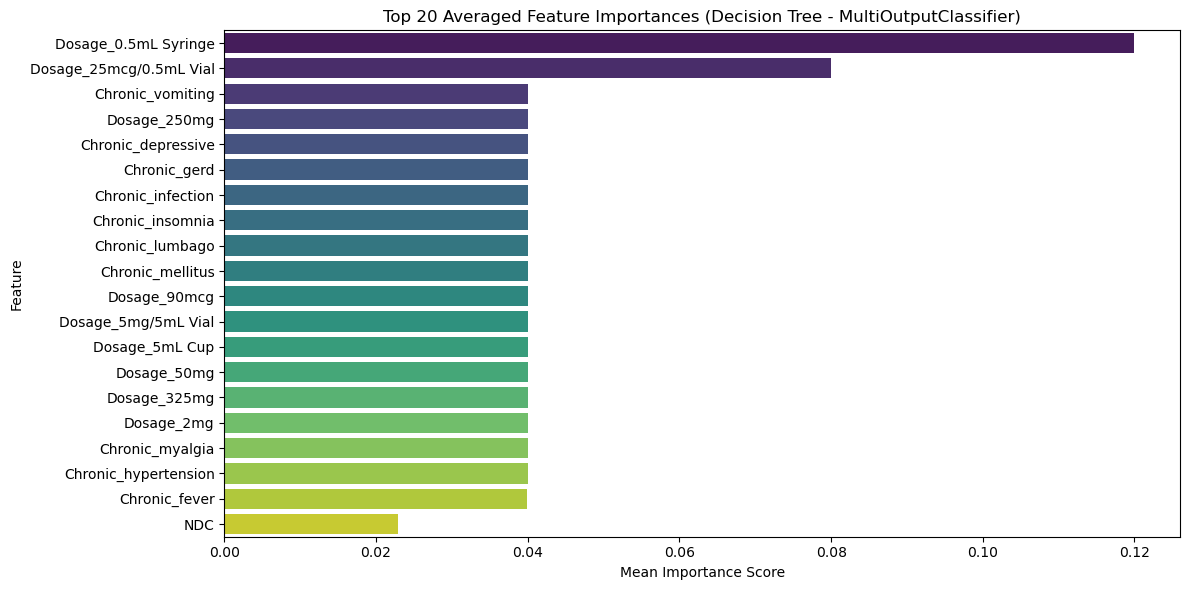

In [290]:
dt_model = MultiOutputClassifier(DecisionTreeClassifier(random_state=42))
dt_model.fit(X_train_processed_df, y_train_df)

importances = np.array([est.feature_importances_ for est in dt_model.estimators_])

# Average across all output labels (multi-label)
mean_importances = importances.mean(axis=0)

# Convert to Series for plotting
importances_series = pd.Series(mean_importances, index=X_train_processed_df.columns)
top_importances = importances_series.sort_values(ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_importances.values, y=top_importances.index, palette="viridis")
plt.title("Top 20 Averaged Feature Importances (Decision Tree - MultiOutputClassifier)")
plt.xlabel("Mean Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

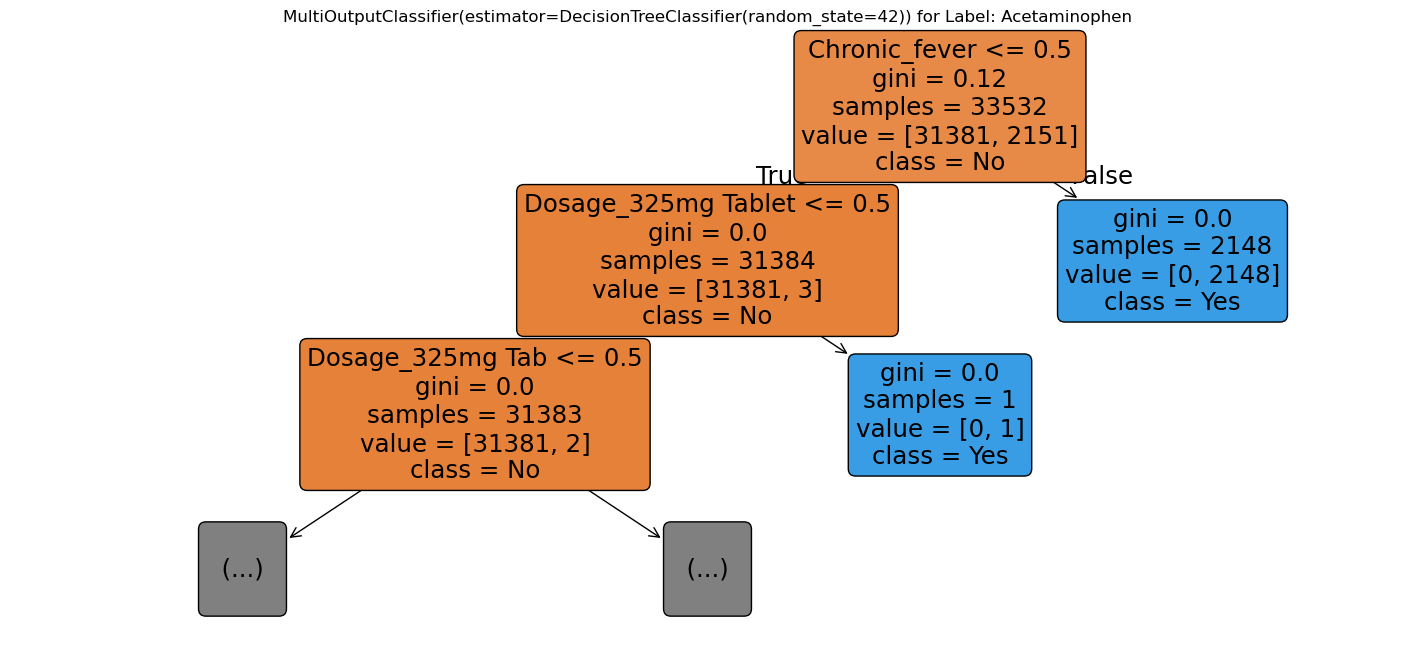

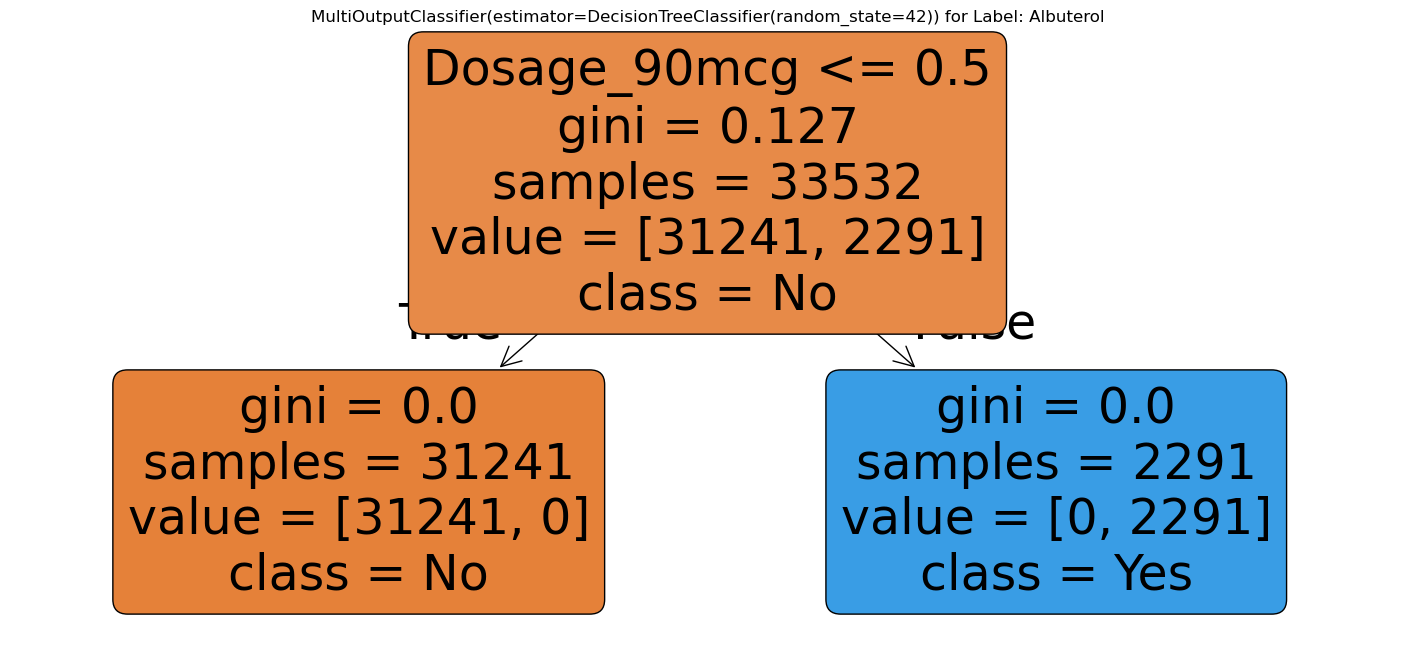

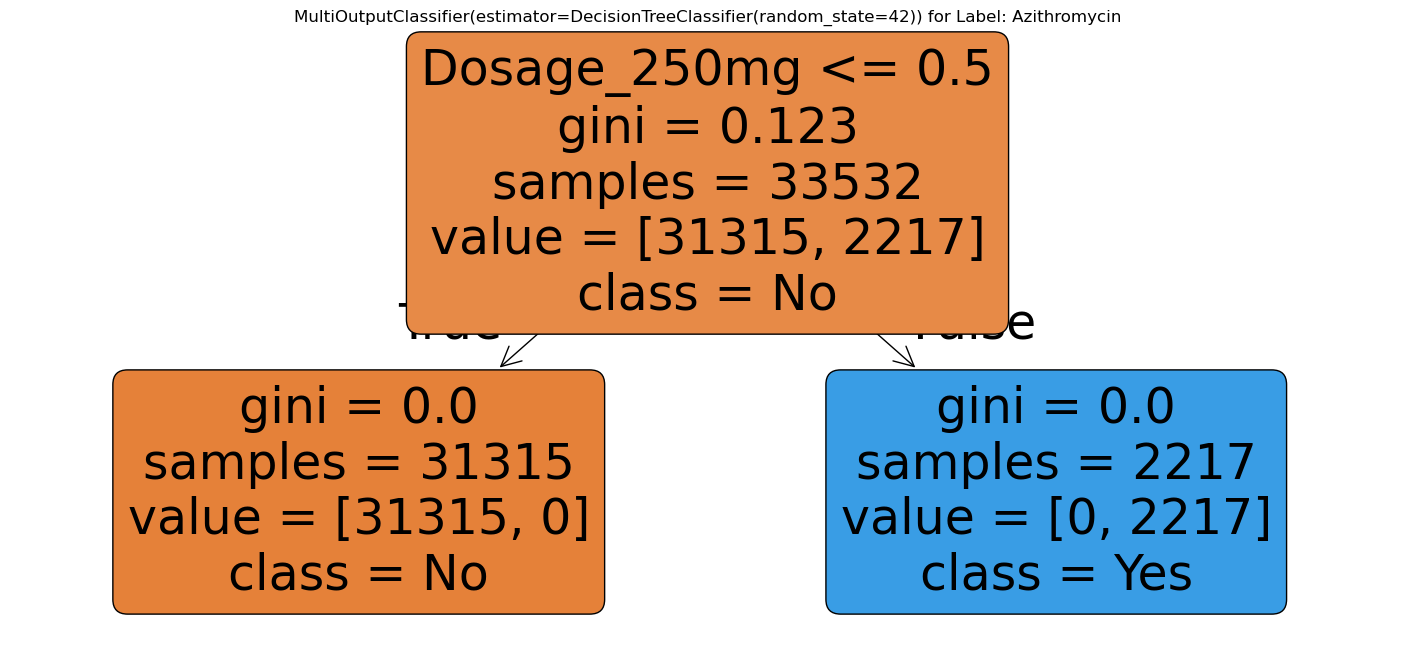

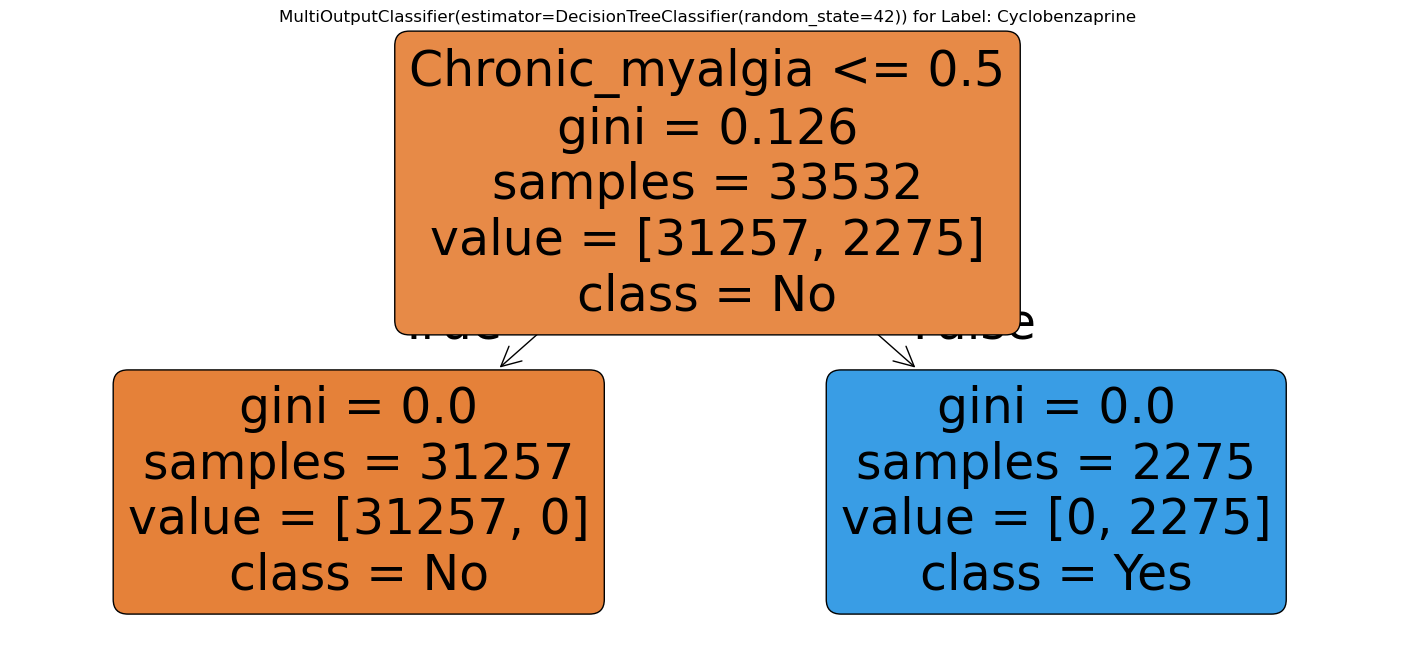

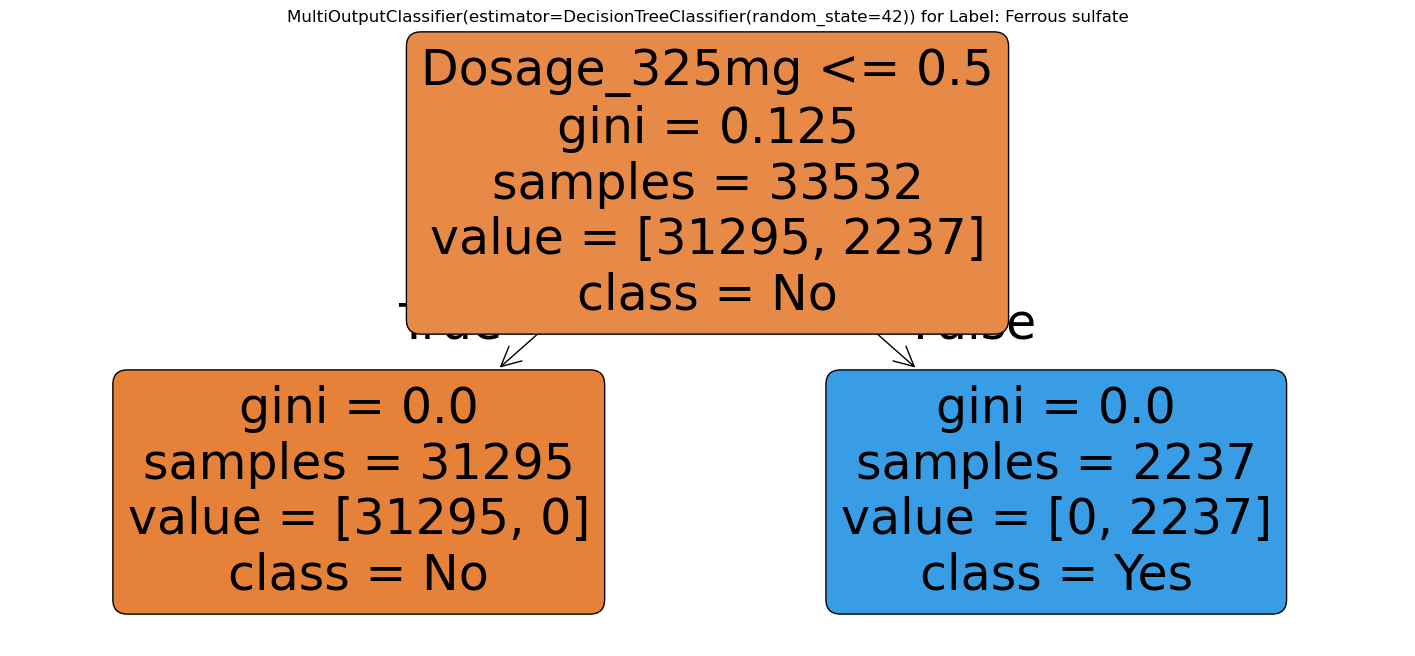

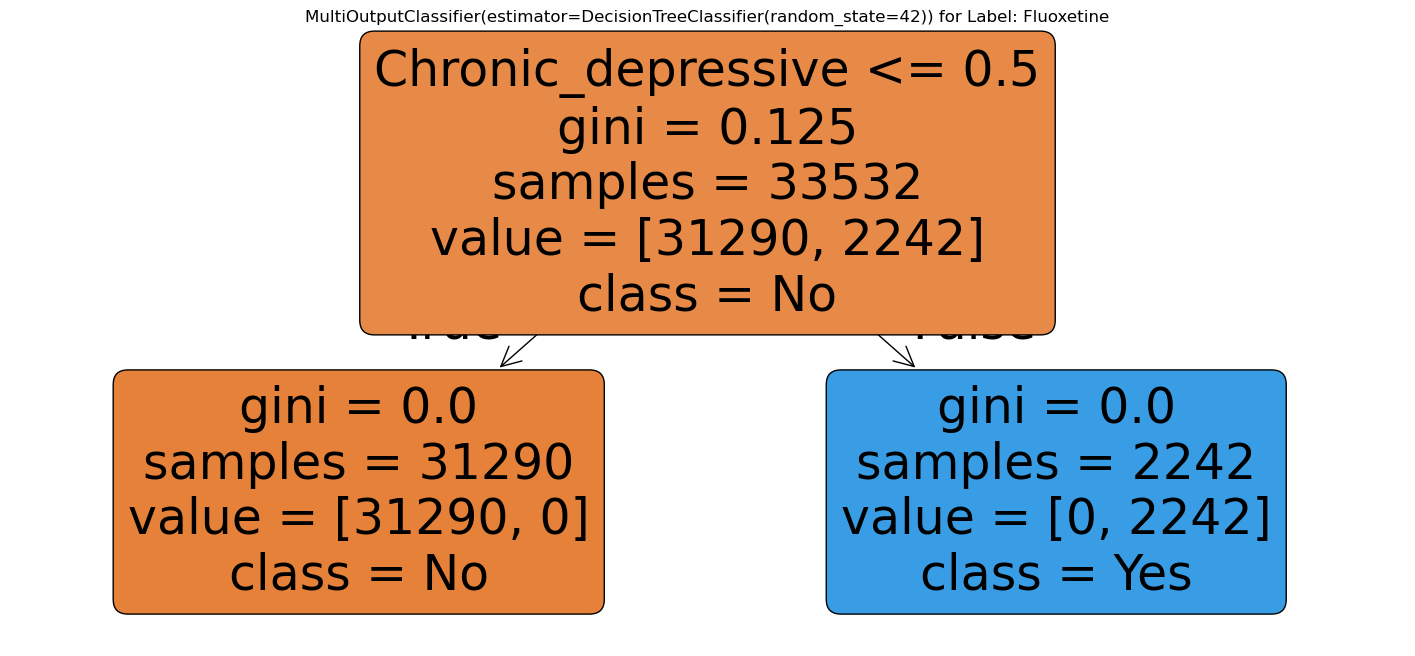

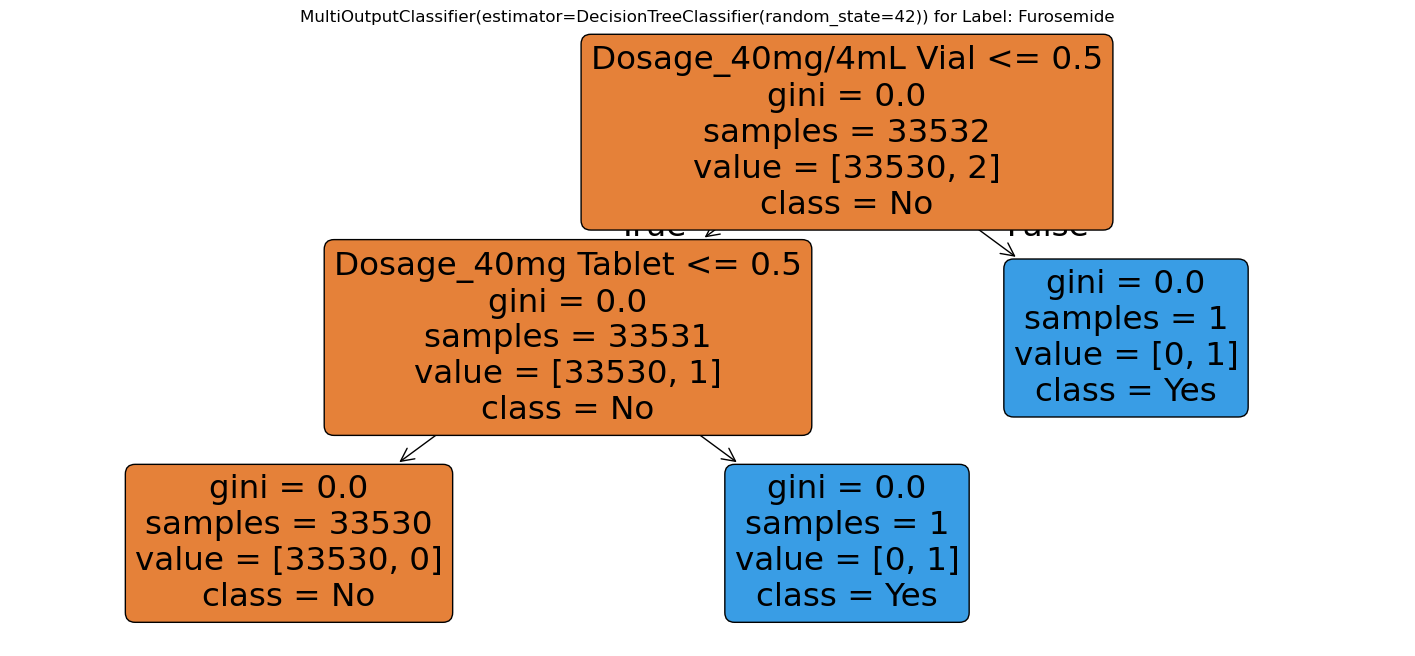

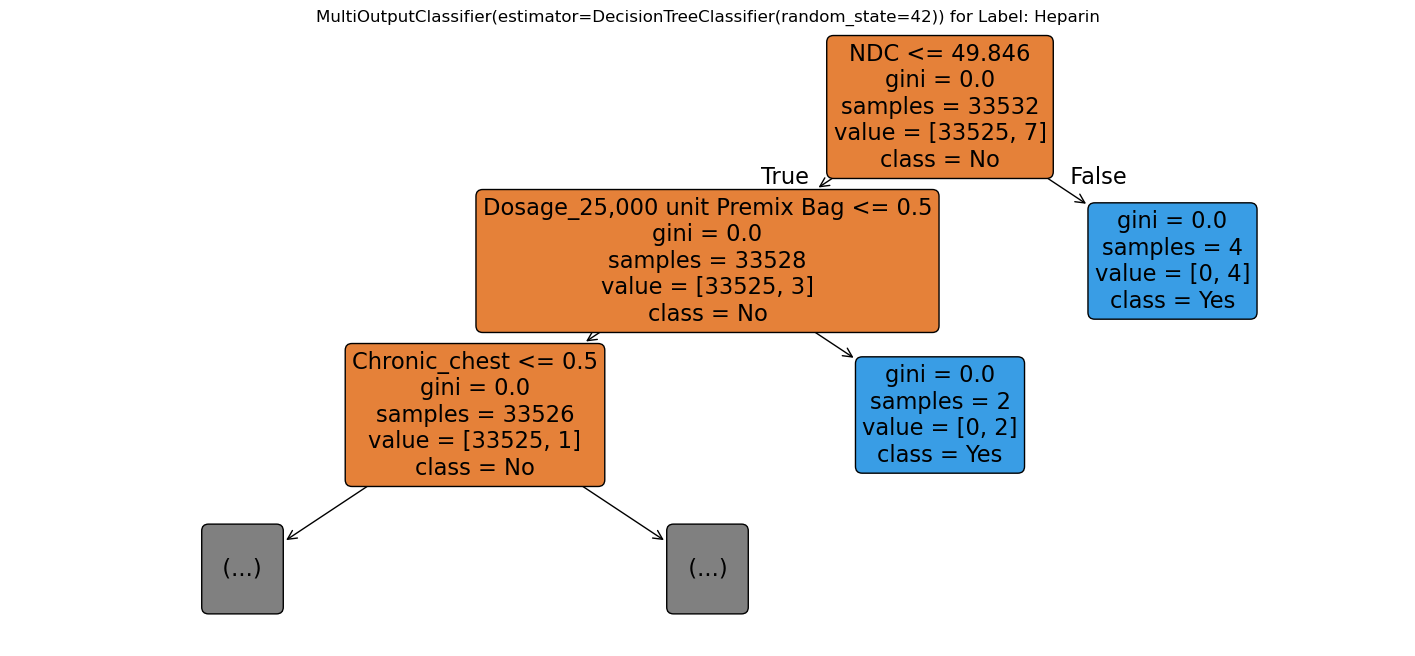

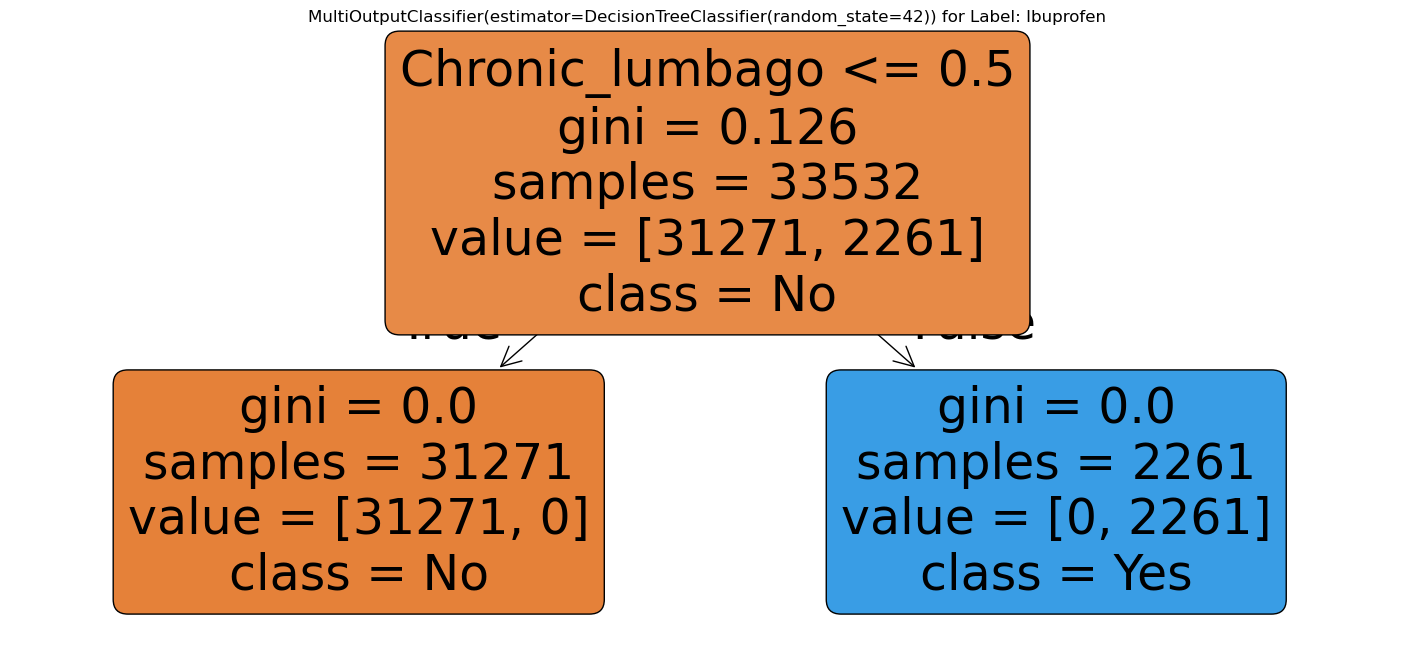

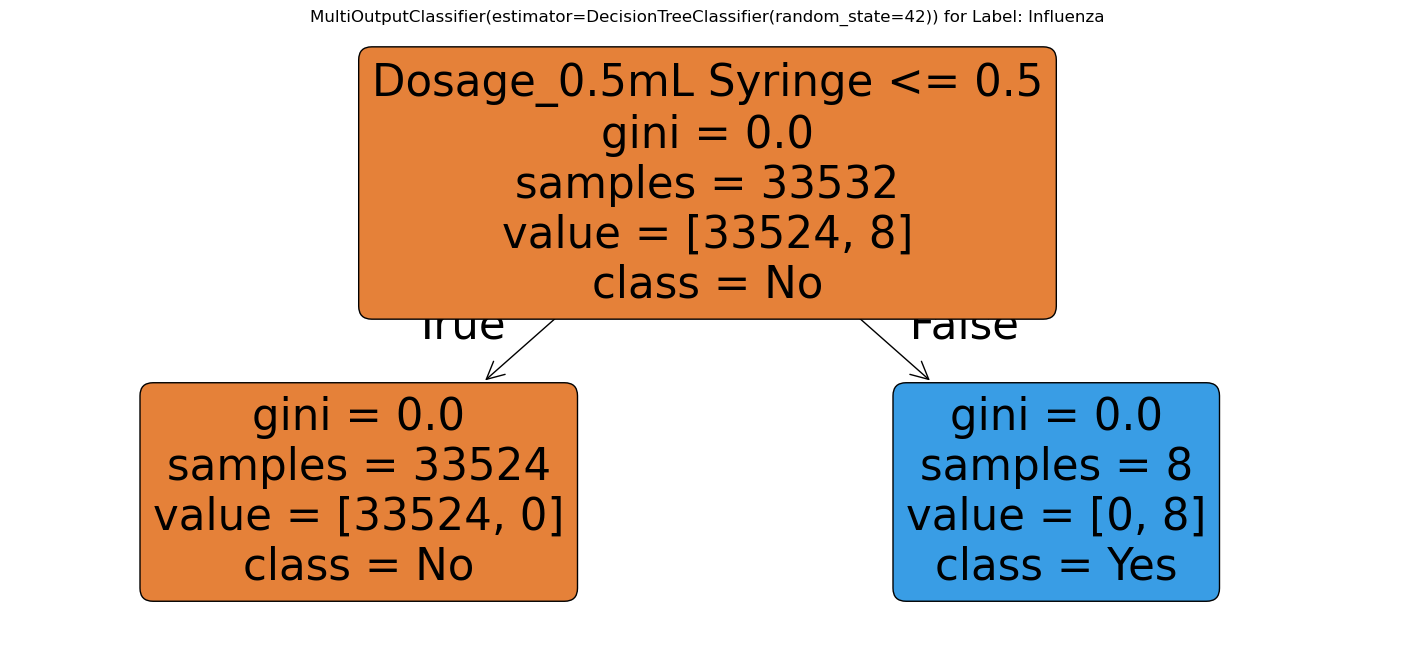

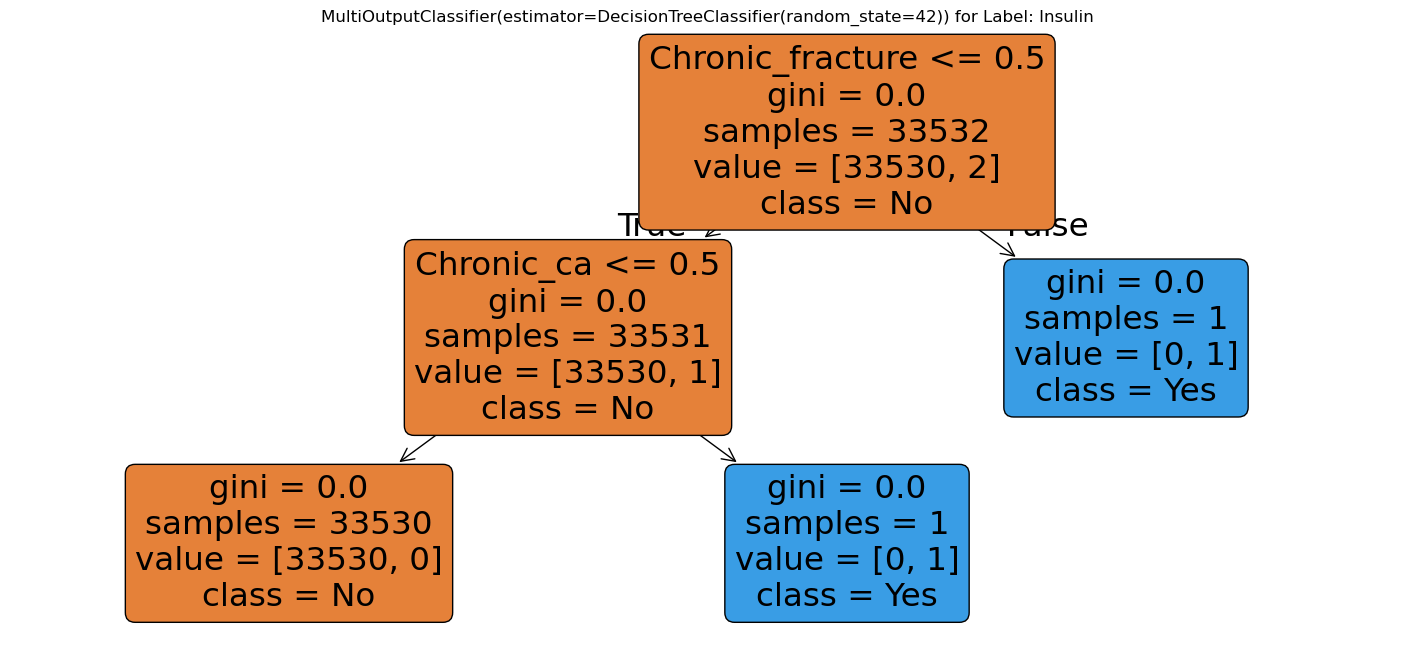

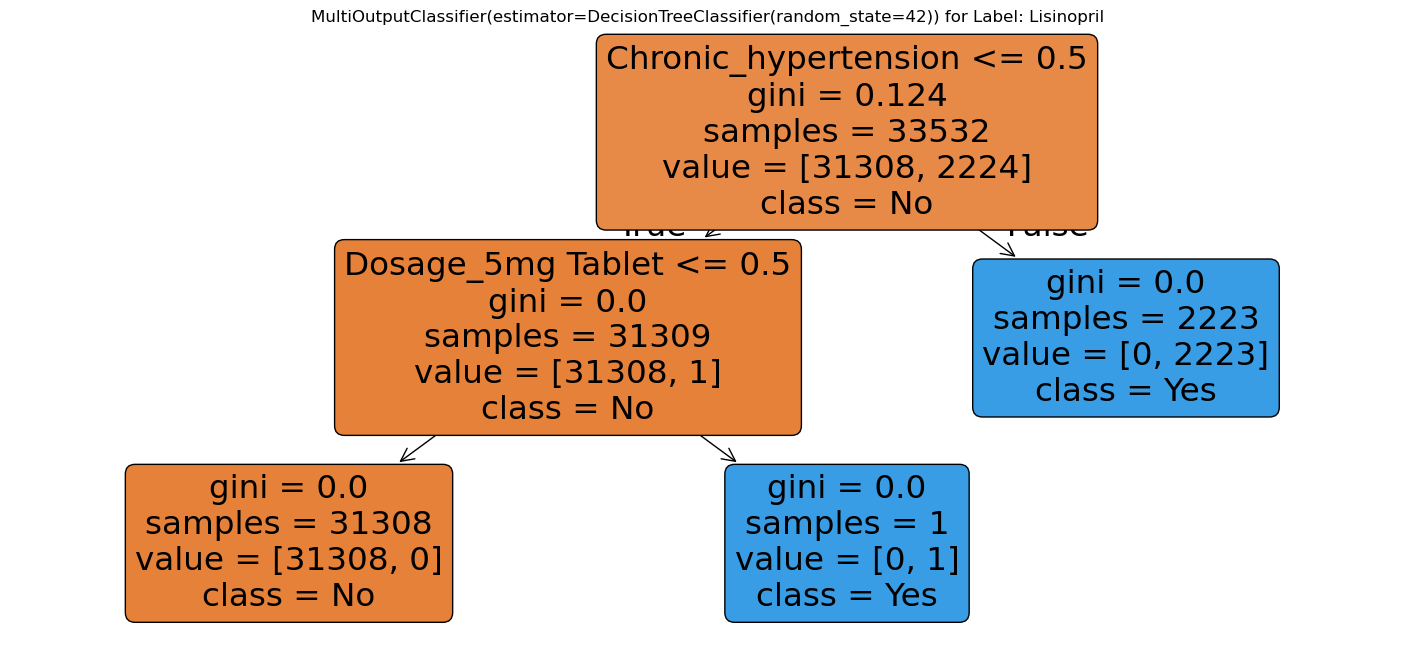

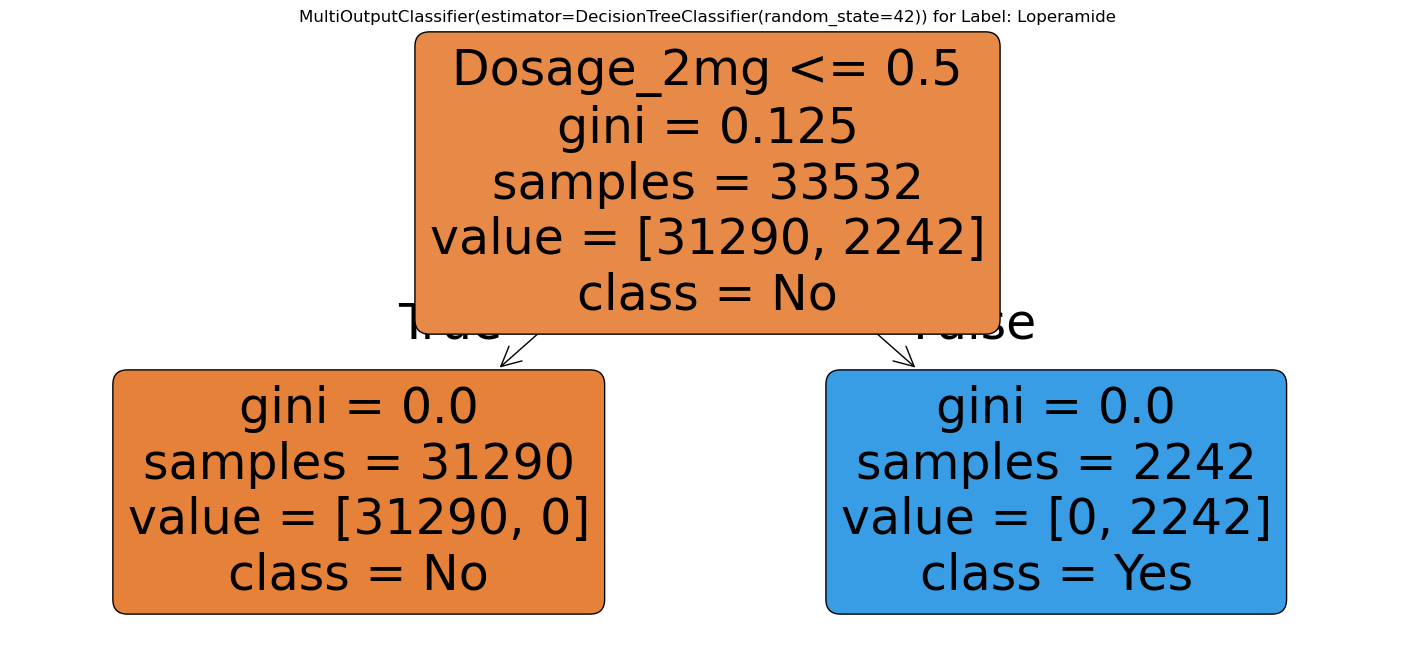

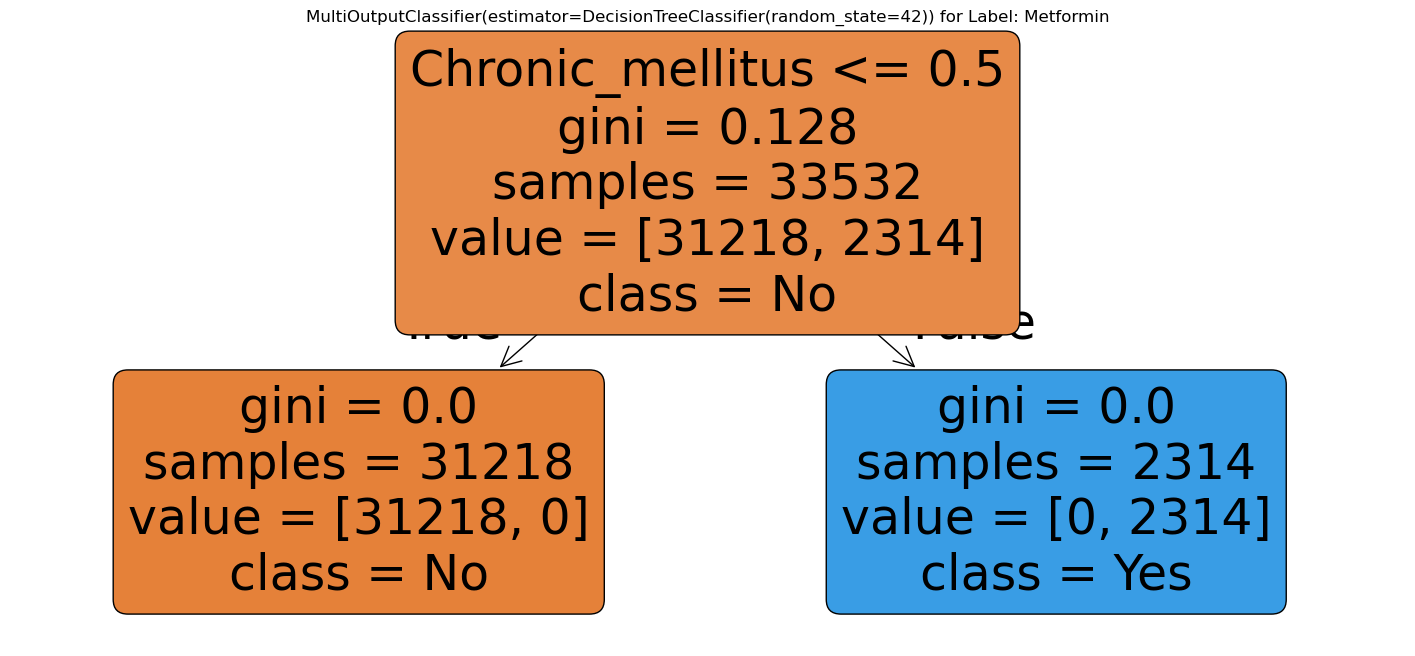

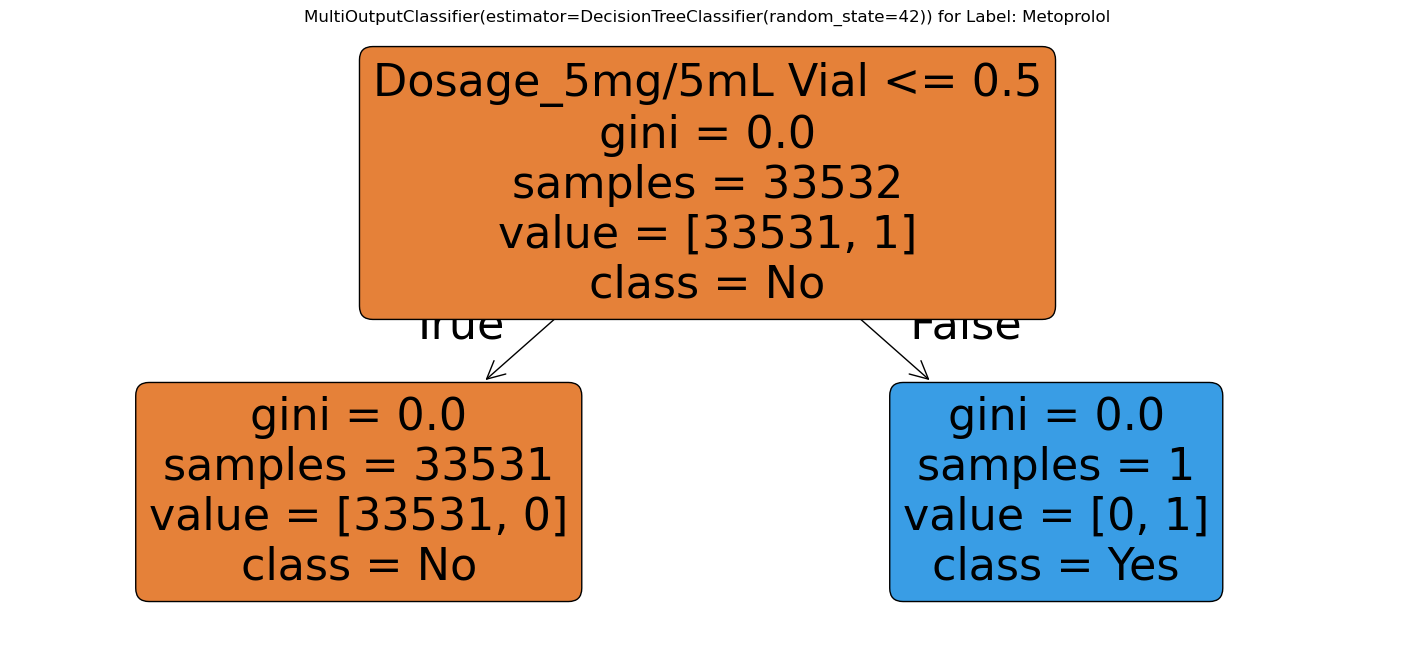

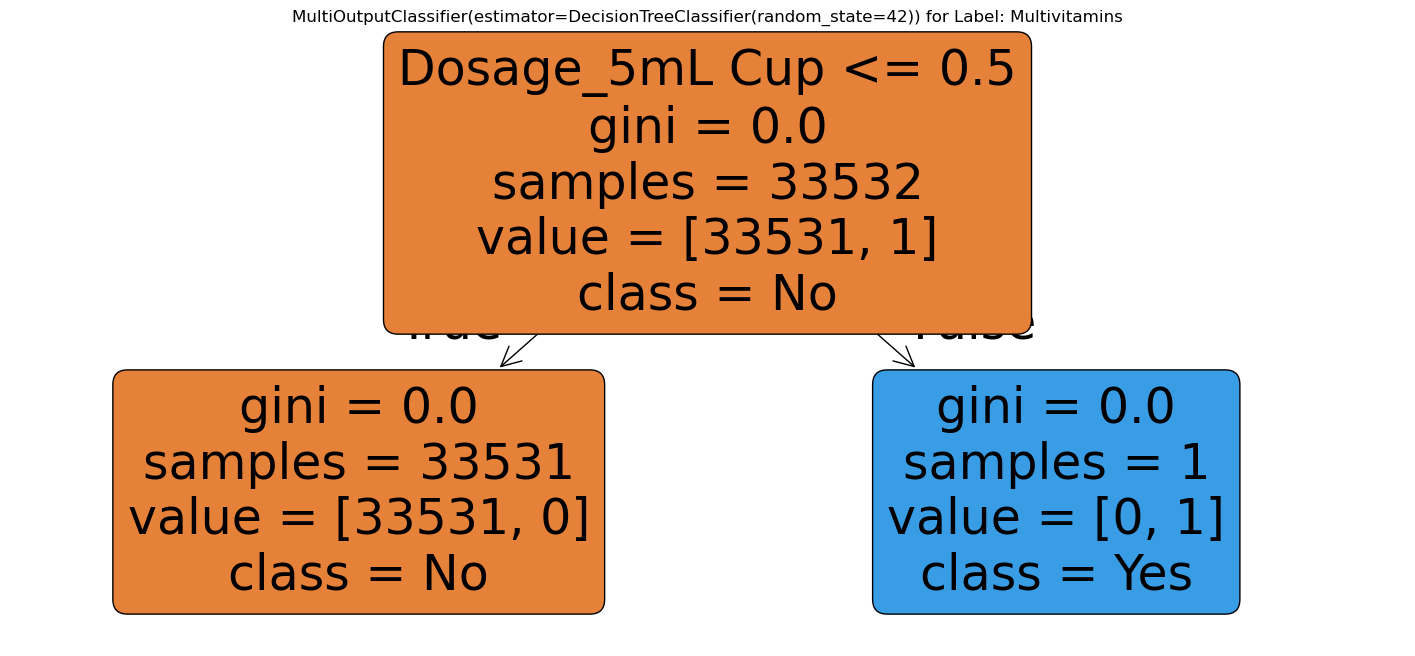

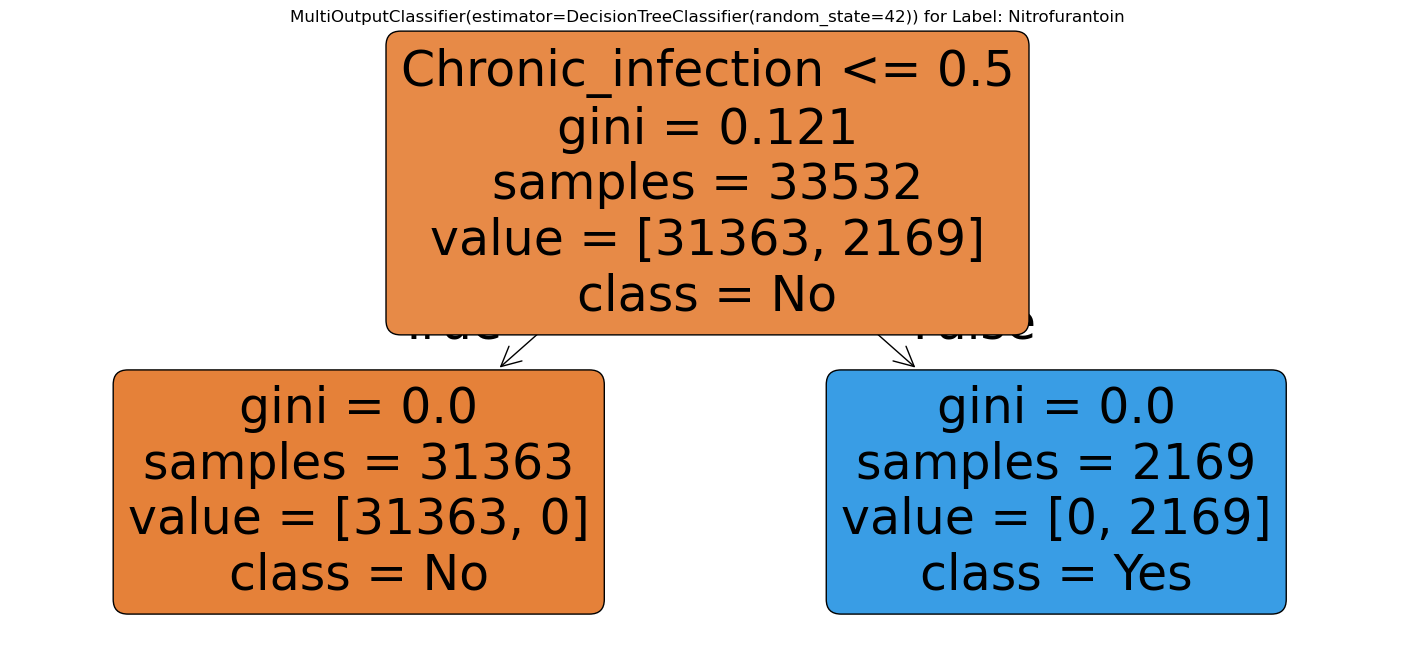

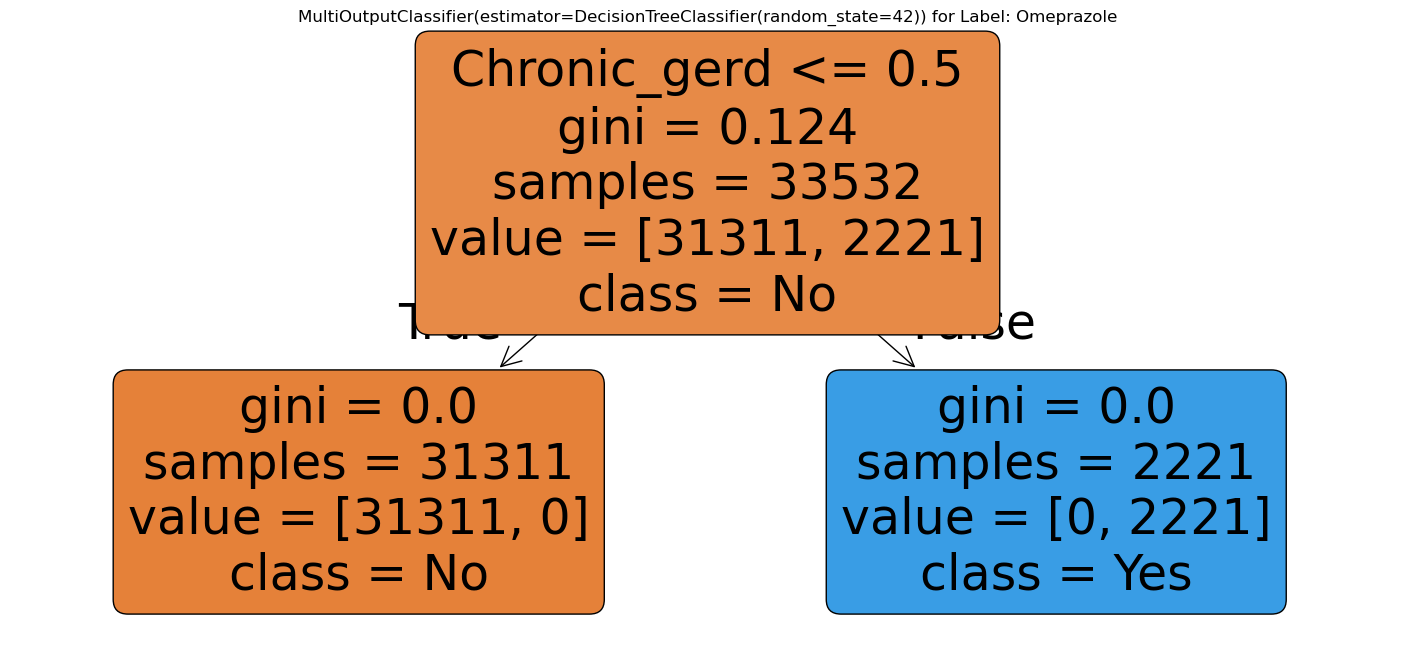

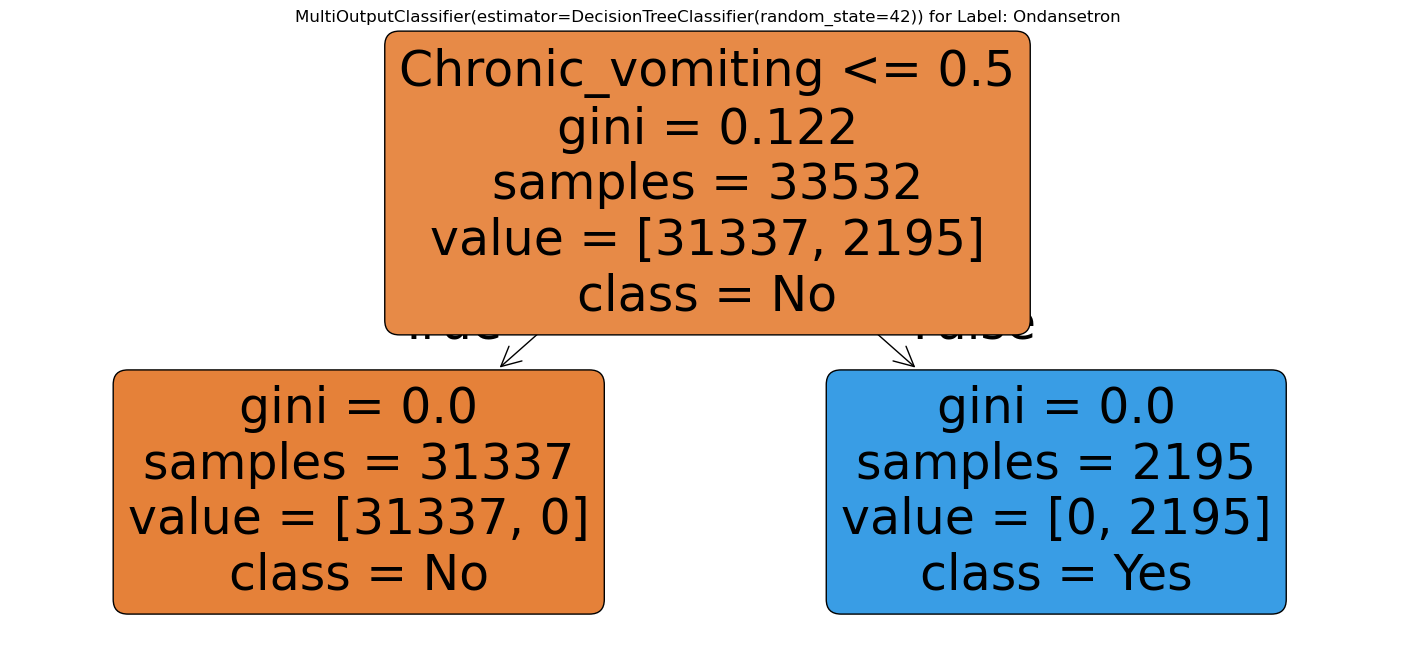

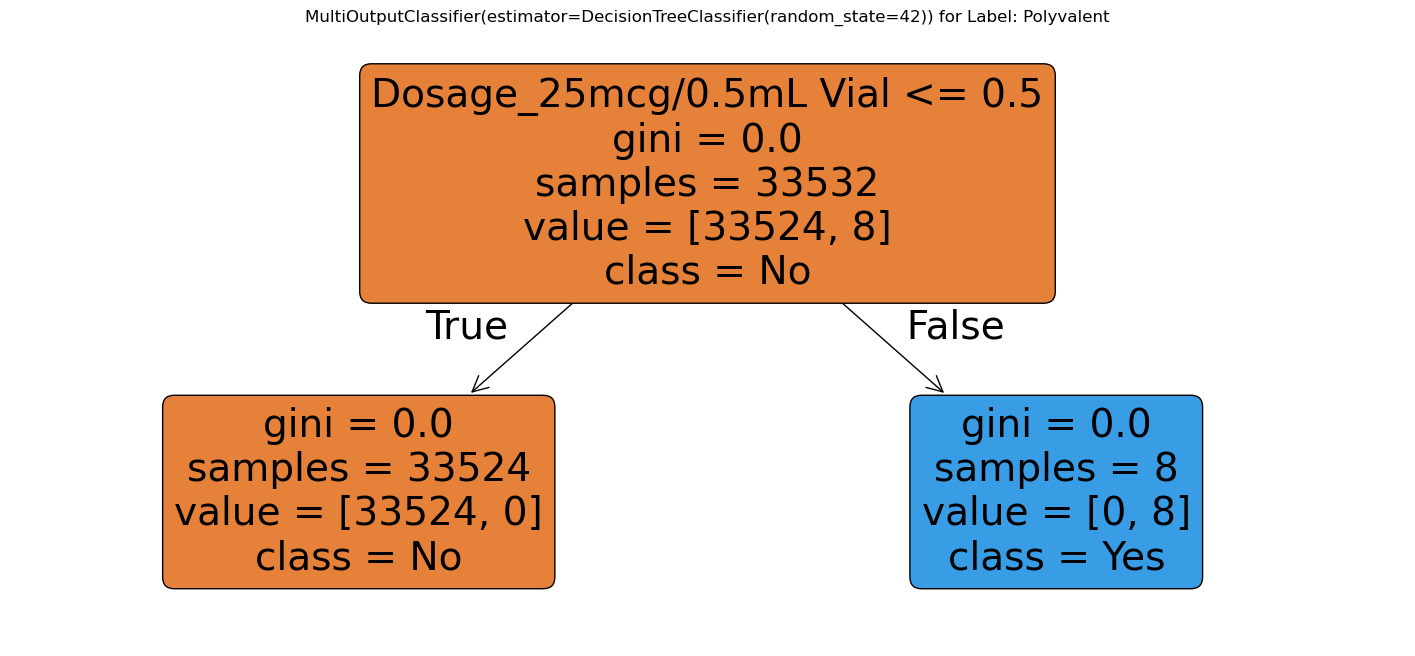

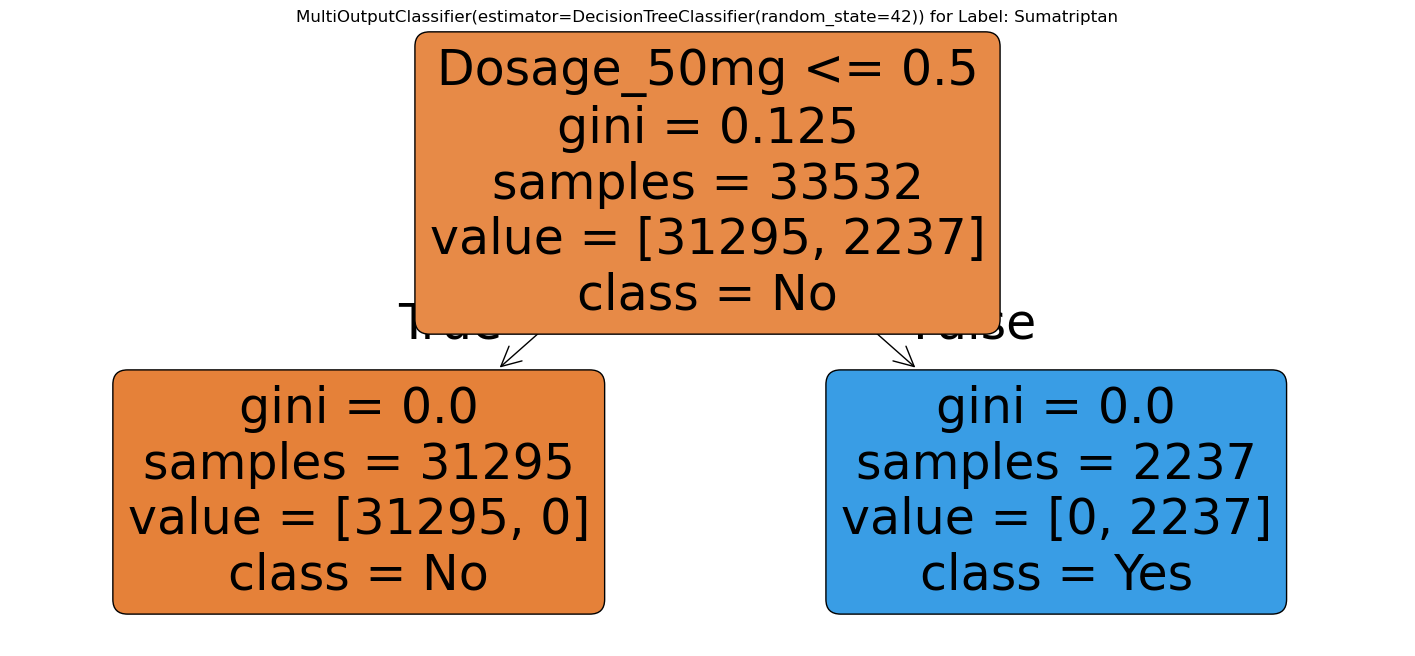

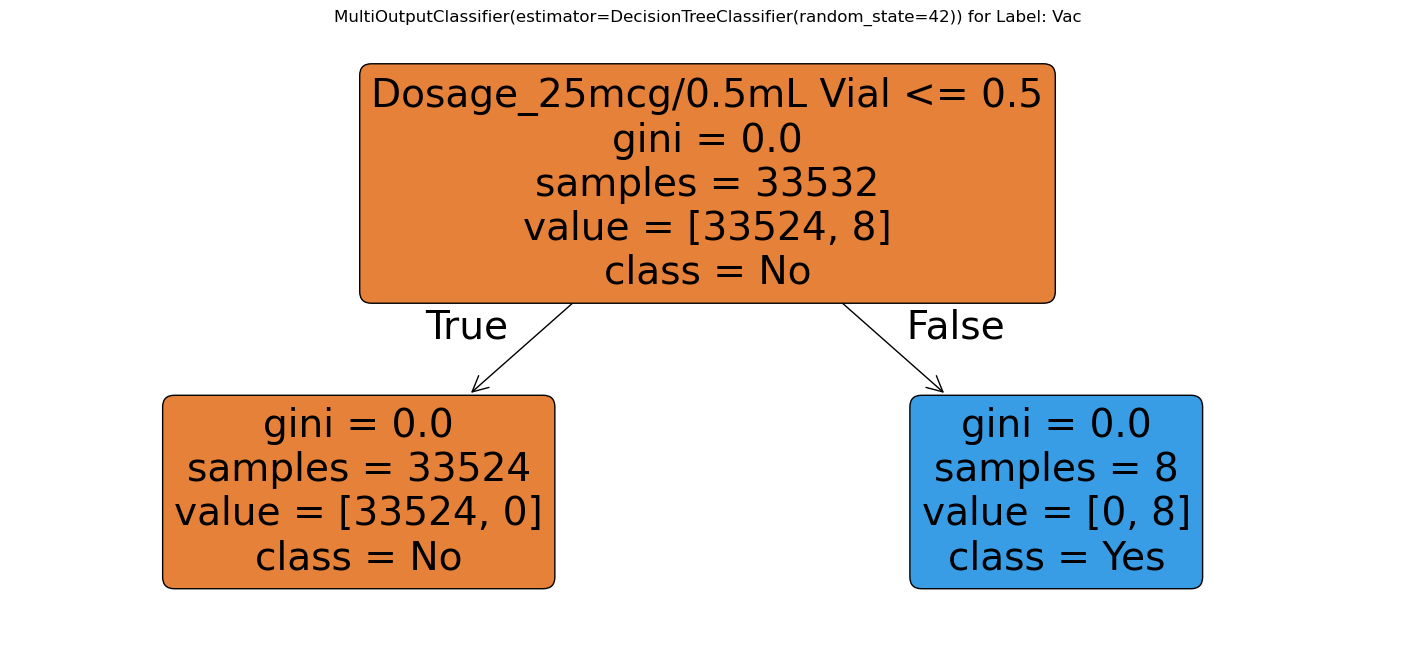

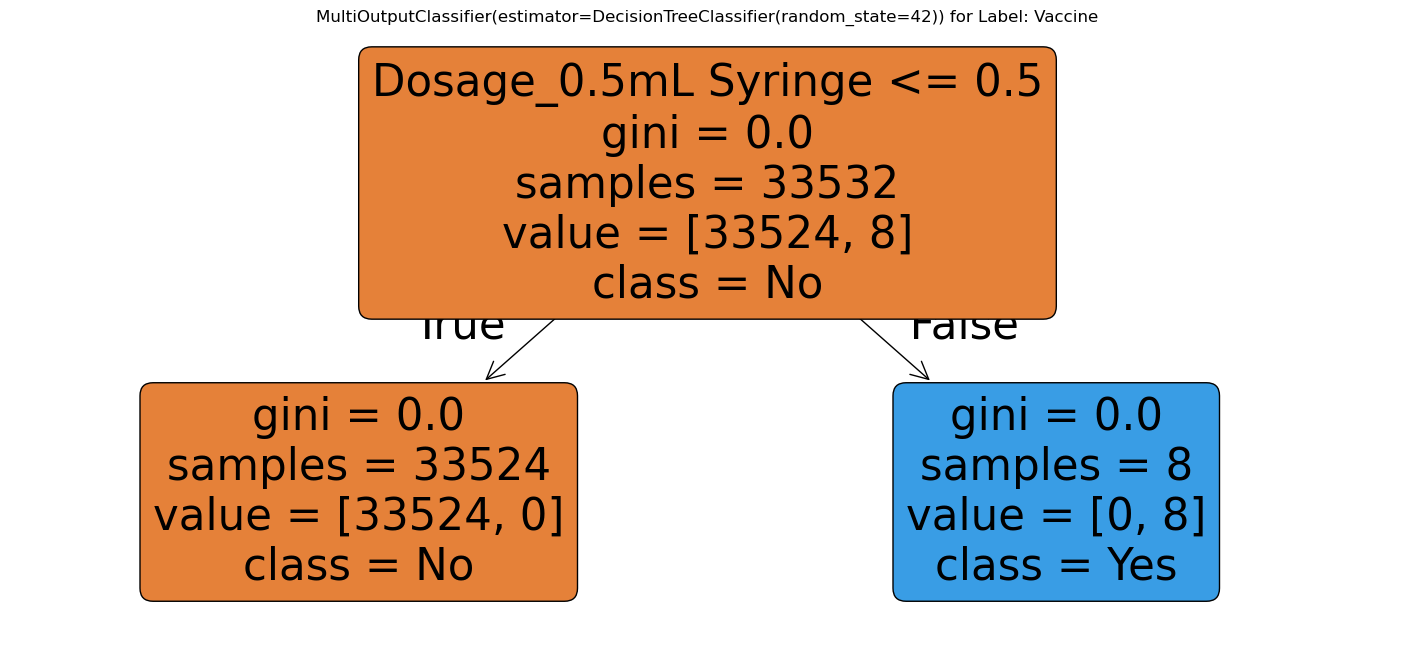

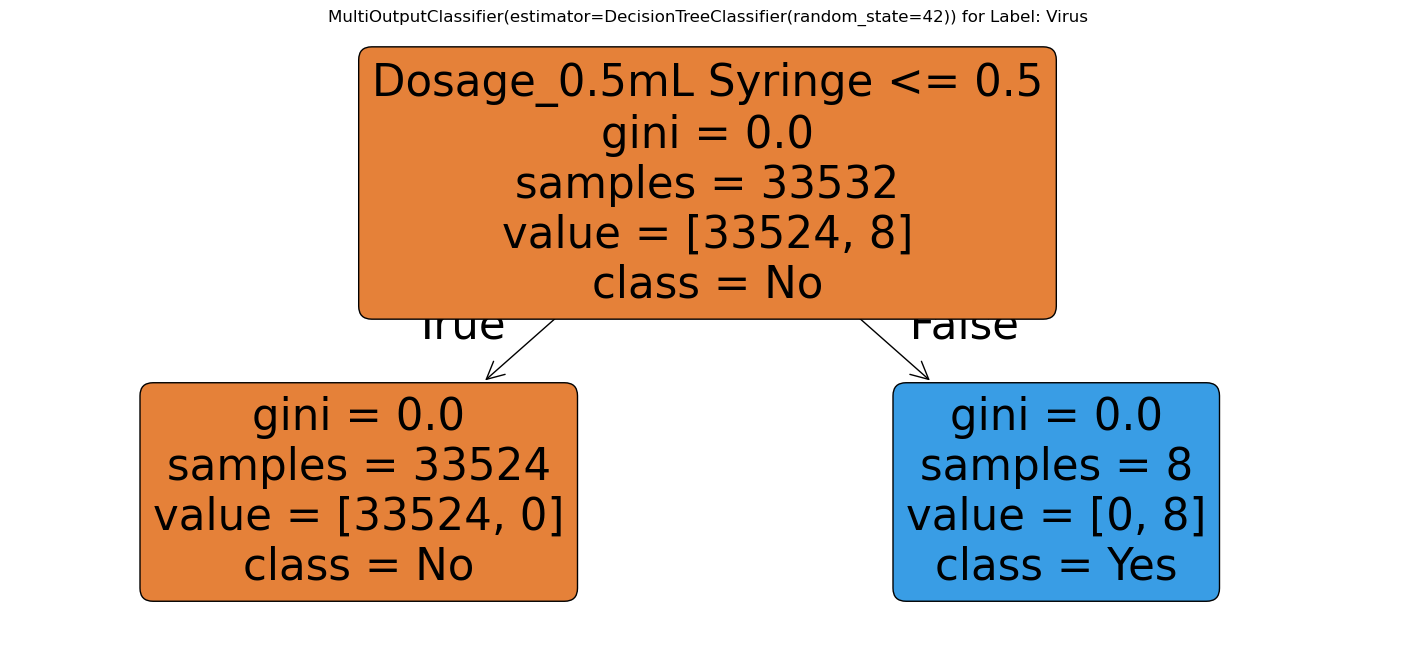

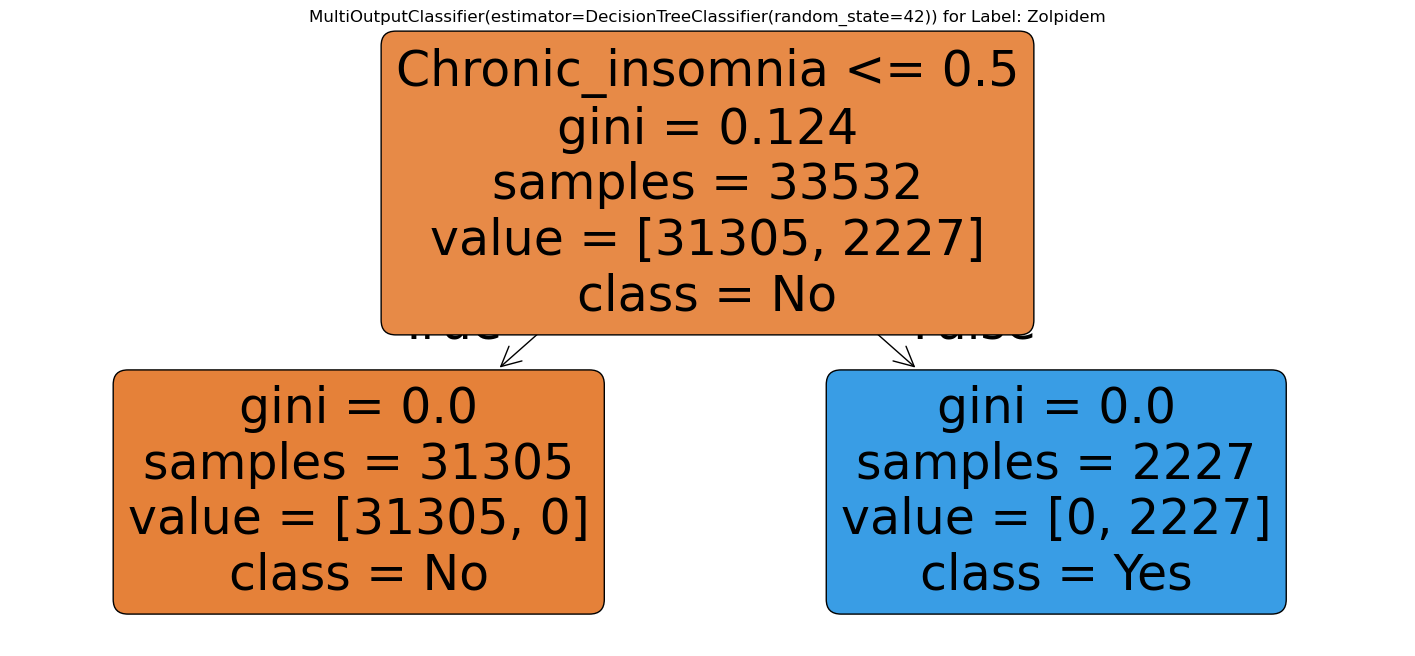

In [294]:
for label, estimator in zip(y_train_df.columns, dt_model.estimators_):
    plt.figure(figsize=(18, 8))
    plot_tree(estimator, 
              feature_names=X_test_processed_df.columns, 
              class_names=["No", "Yes"], 
              filled=True, 
              max_depth=2, 
              rounded=True)
    plt.title(f"{dt_model} for Label: {label}")
    plt.show()